# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

!pip install gensim
from gensim.models import Word2Vec

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import GRU, Bidirectional

import nltk
from nltk.tokenize import word_tokenize
import string

nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Read Dataset

In [ ]:
train_data = pd.read_csv('/kaggle/input/datasett/train_data.csv')
val_data = pd.read_csv('/kaggle/input/datasett/val_data.csv')
test_data = pd.read_csv('/kaggle/input/datasett/test_data.csv')

In [ ]:
train_data.head()

preprocessed_text  label
0  love job love kid time feel like person leave ...      0
1                  think girl feel way guy like tell      2
2                                     feel depressed      0
3      feel come assaulted wall wildly dynamic sound      4
4  feel throw away rotten vegetable double realiz...      0

In [ ]:
val_data.head()

preprocessed_text  label
0          struggle lot writer block feeling inspire      1
1                               want know feel needy      0
2  discover bloke life feel pretty pissed thou de...      3
3                            hope feel tomorrow well      1
4                                      feel honoured      1

In [ ]:
test_data.head()

preprocessed_text  label
0                      feel particularly neurotic      4
1  feel little overwhelmed think lot easy welding      4
2                        feel important influence      1
3                                     feel afraid      4
4                                     feel lonely      0

In [ ]:
train_data['label'].value_counts()

label
1    112620
0     96787
3     45781
4     38127
2     27598
5     11967
Name: count, dtype: int64

In [ ]:
val_data['label'].value_counts()

label
1    14078
0    12098
3     5722
4     4766
2     3450
5     1496
Name: count, dtype: int64

In [ ]:
test_data['label'].value_counts()

label
1    14078
0    12099
3     5723
4     4766
2     3449
5     1496
Name: count, dtype: int64

# WORD2VEC

Word2Vec bekerja dengan mengubah kata-kata menjadi vektor angka yang merepresentasikan makna atau hubungannya dengan kata lain. Algoritma ini belajar dari konteks kata-kata di kalimat: jika dua kata sering muncul dalam konteks yang mirip, vektor mereka akan dekat satu sama lain. Jadi, Word2Vec membantu model memahami hubungan semantik antar kata, bukan hanya sekadar melihat teks sebagai kumpulan huruf.

In [ ]:
train_data['tokens'] = train_data['preprocessed_text'].apply(lambda x: x.split())
val_data['tokens'] = val_data['preprocessed_text'].apply(lambda x: x.split())
test_data['tokens'] = test_data['preprocessed_text'].apply(lambda x: x.split())

In [ ]:
import os
print("Number of CPUs available:", os.cpu_count())

Number of CPUs available: 4


Jumlah CPU yang tersedia di sistem ada **4 CPU**. Jumlah ini nantinya bisa digunakan untuk mengatur nilai parameter **`workers`** pada Word2Vec. Parameter **`workers`** menentukan jumlah thread yang digunakan untuk mempercepat proses pelatihan model Word2Vec, sehingga dengan 4 CPU, kita bisa mengatur **`workers=4`** untuk memanfaatkan semua core CPU secara optimal.

In [ ]:
from collections import Counter
all_tokens = [token for tokens in train_data['tokens'] for token in tokens]
word_counts = Counter(all_tokens)
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
word_frequency_df = pd.DataFrame(sorted_word_counts, columns=["Word", "Frequency"])
word_frequency_df

Word  Frequency
0           feel     334297
1           like      61256
2        feeling      22861
3           know      22655
4           want      20758
...          ...        ...
33954     scapes          1
33955       alts          1
33956  herbalism          1
33957    studies          1
33958      undid          1

[33959 rows x 2 columns]

In [ ]:
words_with_frequency_1 = word_frequency_df[word_frequency_df["Frequency"] == 1]
words_with_frequency_1

Word  Frequency
24399  defeatist          1
24400    pinhole          1
24401     onside          1
24402   aviation          1
24403     skirts          1
...          ...        ...
33954     scapes          1
33955       alts          1
33956  herbalism          1
33957    studies          1
33958      undid          1

[9560 rows x 2 columns]

In [ ]:
words_with_frequency_2 = word_frequency_df[word_frequency_df["Frequency"] == 2]
words_with_frequency_2

Word  Frequency
19868         yearned          2
19869          floras          2
19870     freemasonry          2
19871           crise          2
19872          briggs          2
...               ...        ...
24394          meagan          2
24395        breastfe          2
24396         noodles          2
24397  constructivism          2
24398         moulder          2

[4531 rows x 2 columns]

Kata dengan frekuensi 1 kurang jelas dan kemungkinan tidak signifikan, sehingga lebih baik menggunakan kata dengan frekuensi minimal 2. Oleh karena itu, parameter **min_count=2** dipilih untuk Word2Vec agar hanya kata-kata yang lebih relevan yang diproses.

In [ ]:
word2vec_model = Word2Vec(sentences=train_data['tokens'], vector_size=75, window=5, min_count=2, workers=4)

Pada Word2Vec, **vector_size=75** sudah cukup untuk merepresentasikan kata-kata dengan baik tanpa membuat model terlalu berat secara komputasi. Ukuran yang lebih besar mungkin memberikan detail lebih, tetapi akan membutuhkan lebih banyak memori dan waktu untuk pelatihan, sementara 75 sudah memberikan keseimbangan yang baik untuk dataset ini.

**Window=5** dipilih karena dari analisis n-gram sebelumnya, pola-pola unik untuk setiap emosi mulai terlihat pada n-gram dengan panjang 5. Jadi, window size ini memungkinkan model menangkap konteks kata secara optimal tanpa kehilangan pola penting antar kata.

In [ ]:
def get_word2vec_sequence(tokens, model, vector_size=75):
    sequence = []
    for token in tokens:
        if token in model.wv:
            sequence.append(model.wv[token])
        else:
            sequence.append(np.zeros(vector_size))
    return sequence

train_data['sequence'] = train_data['tokens'].apply(lambda x: get_word2vec_sequence(x, word2vec_model))
val_data['sequence'] = val_data['tokens'].apply(lambda x: get_word2vec_sequence(x, word2vec_model))
test_data['sequence'] = test_data['tokens'].apply(lambda x: get_word2vec_sequence(x, word2vec_model))

Proses diatas mengubah token dalam setiap teks menjadi urutan vektor Word2Vec berdasarkan model yang dilatih. Jika token tidak ada di Word2Vec, akan digantikan dengan vektor nol, sehingga semua teks diwakili dalam bentuk vektor untuk digunakan dalam model.

In [ ]:
X_train_word2vec = pad_sequences(train_data['sequence'], maxlen=66, padding='post', dtype='float32')
X_val_word2vec = pad_sequences(val_data['sequence'], maxlen=66, padding='post', dtype='float32')
X_test_word2vec = pad_sequences(test_data['sequence'], maxlen=66, padding='post', dtype='float32')

Pada proses padding ini, nilai **maxlen** ditentukan berdasarkan hasil EDA sebelumnya, di mana panjang teks terpanjang dalam dataset adalah **66 kata**. Oleh karena itu, semua teks dipadatkan hingga panjang maksimal 66 untuk memastikan konsistensi input ke model.

In [ ]:
y_train = train_data['label']
y_val = val_data['label']
y_test = test_data['label']

In [ ]:
input_dim=X_train_word2vec.shape[1]

`input_dim=X_train_word2vec.shape[1]` digunakan untuk menentukan panjang urutan input (sequence length) agar sesuai dengan dimensi data hasil padding, yaitu 66.

In [ ]:
word2vec_model.save("word2vec_model.model")

`word2vec_model.save("word2vec_model.model")`digunakan untuk save vektorisasi word2vec yang sudah ditrain untuk nantinya dapat digunakan pada saat implementasi.

In [ ]:
def create_gru_model(input_dim, learning_rate=0.001):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim, 75)))
    model.add(layers.GRU(64, return_sequences=False))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(6, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
def create_bigru_model(input_dim, learning_rate=0.001):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim, 75)))
    model.add(Bidirectional(GRU(64, return_sequences=False)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(6, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
def create_lstm_model(input_dim, learning_rate=0.001):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim, 75)))
    model.add(layers.LSTM(64, return_sequences=False))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(6, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
def create_bilstm_model(input_dim, learning_rate=0.001):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim, 75)))
    model.add(Bidirectional(layers.LSTM(64, return_sequences=False)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(6, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_confusion_matrix(model, X_test, y_test, num_classes):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_test, y_pred_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(num_classes)], yticklabels=[f'Class {i}' for i in range(num_classes)])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [ ]:
def train_and_evaluate(input_dim, batch_size, learning_rate, epochs, X_train, y_train, X_val, y_val, X_test, y_test, model_type='gru'):
    # Select the model type
    if model_type == 'gru':
        model = create_gru_model(input_dim, learning_rate=learning_rate)
    elif model_type == 'bigru':
        model = create_bigru_model(input_dim, learning_rate=learning_rate)
    elif model_type == 'lstm':
        model = create_lstm_model(input_dim, learning_rate=learning_rate)
    elif model_type == 'bilstm':
        model = create_bilstm_model(input_dim, learning_rate=learning_rate)
    else:
        raise ValueError("Invalid model_type. Choose 'gru', 'bigru', 'lstm', or 'bilstm'.")

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs, batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping]
    )

    # Plot training history
    print("\nTraining History:\n")
    plot_training_history(history)

    # Evaluate on test data
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Classification report
    report = classification_report(y_test, y_pred_labels)

    print("\nClassification Report:\n")
    print(report)

    # Calculate AUC
    try:
        test_auc = roc_auc_score(tf.keras.utils.to_categorical(y_test, num_classes=6), y_pred, multi_class='ovr')
    except ValueError:
        test_auc = "AUC not available for fewer than two classes"

    # Metrics
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    precision = classification_report(y_test, y_pred_labels, output_dict=True)['weighted avg']['precision']
    recall = classification_report(y_test, y_pred_labels, output_dict=True)['weighted avg']['recall']
    f1_score = classification_report(y_test, y_pred_labels, output_dict=True)['weighted avg']['f1-score']

    metrics = {
        'Train Loss': train_loss,
        'Val Loss': val_loss,
        'Test Loss': test_loss,
        'AUC': test_auc,
        'Accuracy': test_acc,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score
    }

    # Print metrics
    print("\nMetrics:\n")
    for key, value in metrics.items():
        print(f"{key}: {value}")

    print("")

    # Plot confusion matrix
    plot_confusion_matrix(model, X_test, y_test, num_classes=6)

    return model, metrics, history

## GRU

### 1. Batch 8 & LR 0.01

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 207s 5ms/step - accuracy: 0.3336 - loss: 1.5800 - val_accuracy: 0.3383 - val_loss: 1.5753
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 202s 5ms/step - accuracy: 0.3367 - loss: 1.5760 - val_accuracy: 0.3383 - val_loss: 1.5734
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 204s 5ms/step - accuracy: 0.3346 - loss: 1.5767 - val_accuracy: 0.3383 - val_loss: 1.5755
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 203s 5ms/step - accuracy: 0.3357 - loss: 1.5756 - val_accuracy: 0.3383 - val_loss: 1.5757
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 203s 5ms/step - accuracy: 0.3368 - loss: 1.5746 - val_accuracy: 0.3383 - val_loss: 1.5731
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 203s 5ms/step - accuracy: 0.3368 - loss: 1.5747 - val_accuracy: 0.3383 - val_loss: 1.5766
Epoch 7/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 203s 5ms/step - accuracy: 0.3367 - loss: 1.5751 - val_accuracy: 0.3383 - val_loss: 1.5741
Epoch 8/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 202s 5ms/s

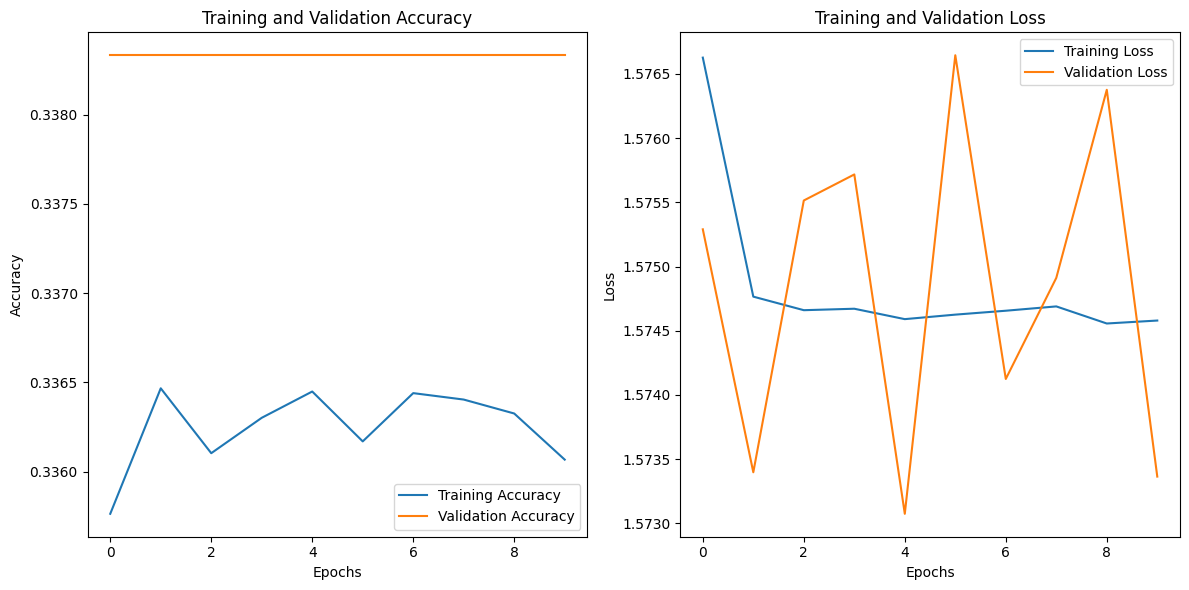

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12099
           1       0.34      1.00      0.51     14078
           2       0.00      0.00      0.00      3449
           3       0.00      0.00      0.00      5723
           4       0.00      0.00      0.00      4766
           5       0.00      0.00      0.00      1496

    accuracy                           0.34     41611
   macro avg       0.06      0.17      0.08     41611
weighted avg       0.11      0.34      0.17     41611


Metrics:

Train Loss: 1.5745794773101807
Val Loss: 1.5733649730682373
Test Loss: 1.5730478763580322
AUC: 0.5
Accuracy: 0.33832401037216187
Precision: 0.11446312956140597
Recall: 0.33832400086515585
F1-Score: 0.171054437471661

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


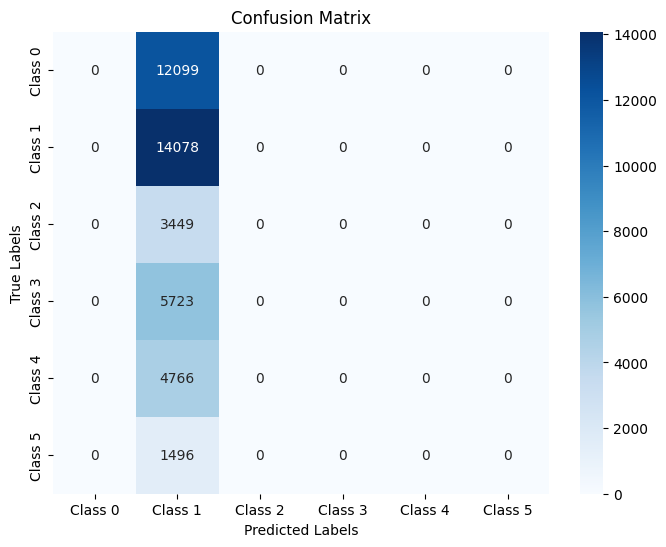


Model saved as 'word2vec_gru_model_1.h5'



In [ ]:
word2vec_gru_model_1, word2vec_gru_metrics_1, word2vec_gru_history_1 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="gru"
)

word2vec_gru_model_1.save('word2vec_gru_model_1.h5')
print("\nModel saved as 'word2vec_gru_model_1.h5'\n")

### 2. Batch 8 & LR 0.001

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 206s 5ms/step - accuracy: 0.3355 - loss: 1.5779 - val_accuracy: 0.3383 - val_loss: 1.5731
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 204s 5ms/step - accuracy: 0.3377 - loss: 1.5746 - val_accuracy: 0.3383 - val_loss: 1.5732
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 203s 5ms/step - accuracy: 0.3382 - loss: 1.5729 - val_accuracy: 0.3383 - val_loss: 1.5730
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 202s 5ms/step - accuracy: 0.3387 - loss: 1.5729 - val_accuracy: 0.3383 - val_loss: 1.5731
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 202s 5ms/step - accuracy: 0.3387 - loss: 1.5713 - val_accuracy: 0.3383 - val_loss: 1.5731
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 202s 5ms/step - accuracy: 0.3388 - loss: 1.5712 - val_accuracy: 0.3383 - val_loss: 1.5731
Epoch 7/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 202s 5ms/step - accuracy: 0.3379 - loss: 1.5739 - val_accuracy: 0.3383 - val_loss: 1.5731
Epoch 8/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 203s 5ms/s

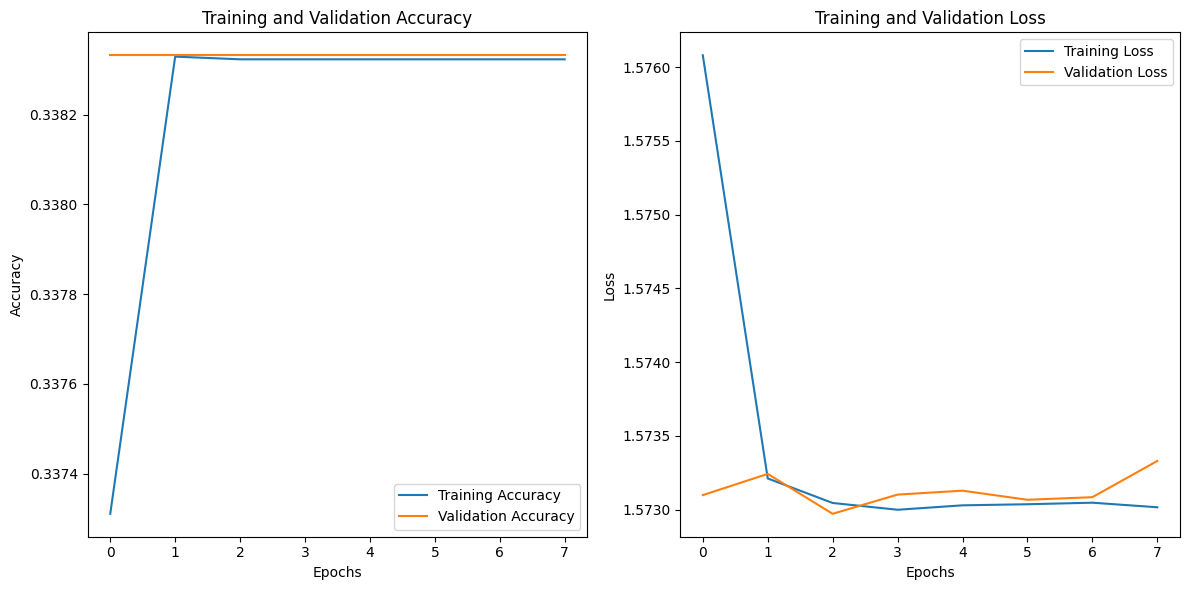

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12099
           1       0.34      1.00      0.51     14078
           2       0.00      0.00      0.00      3449
           3       0.00      0.00      0.00      5723
           4       0.00      0.00      0.00      4766
           5       0.00      0.00      0.00      1496

    accuracy                           0.34     41611
   macro avg       0.06      0.17      0.08     41611
weighted avg       0.11      0.34      0.17     41611


Metrics:

Train Loss: 1.5730170011520386
Val Loss: 1.5733307600021362
Test Loss: 1.5729471445083618
AUC: 0.5
Accuracy: 0.33832401037216187
Precision: 0.11446312956140597
Recall: 0.33832400086515585
F1-Score: 0.171054437471661

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


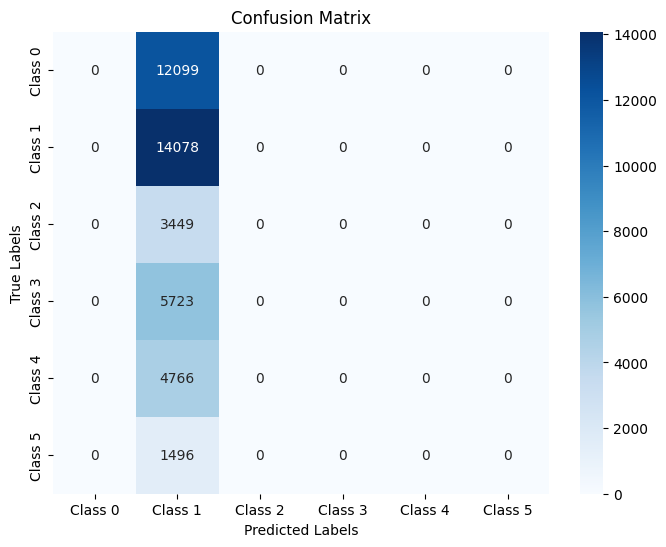


Model saved as 'word2vec_gru_model_2.h5'



In [ ]:
word2vec_gru_model_2, word2vec_gru_metrics_2, word2vec_gru_history_2 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="gru"
)

word2vec_gru_model_2.save('word2vec_gru_model_2.h5')
print("\nModel saved as 'word2vec_gru_model_2.h5'\n")

### 3. Batch 8 & LR 0.0001

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 208s 5ms/step - accuracy: 0.5829 - loss: 1.0902 - val_accuracy: 0.8635 - val_loss: 0.3878
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 205s 5ms/step - accuracy: 0.8726 - loss: 0.3479 - val_accuracy: 0.9093 - val_loss: 0.2303
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 204s 5ms/step - accuracy: 0.9085 - loss: 0.2302 - val_accuracy: 0.9143 - val_loss: 0.1987
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 204s 5ms/step - accuracy: 0.9157 - loss: 0.2006 - val_accuracy: 0.9173 - val_loss: 0.1805
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 204s 5ms/step - accuracy: 0.9189 - loss: 0.1845 - val_accuracy: 0.9200 - val_loss: 0.1741
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 206s 5ms/step - accuracy: 0.9213 - loss: 0.1731 - val_accuracy: 0.9226 - val_loss: 0.1634
Epoch 7/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 205s 5ms/step - accuracy: 0.9223 - loss: 0.1678 - val_accuracy: 0.9223 - val_loss: 0.1622
Epoch 8/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 204s 5ms/s

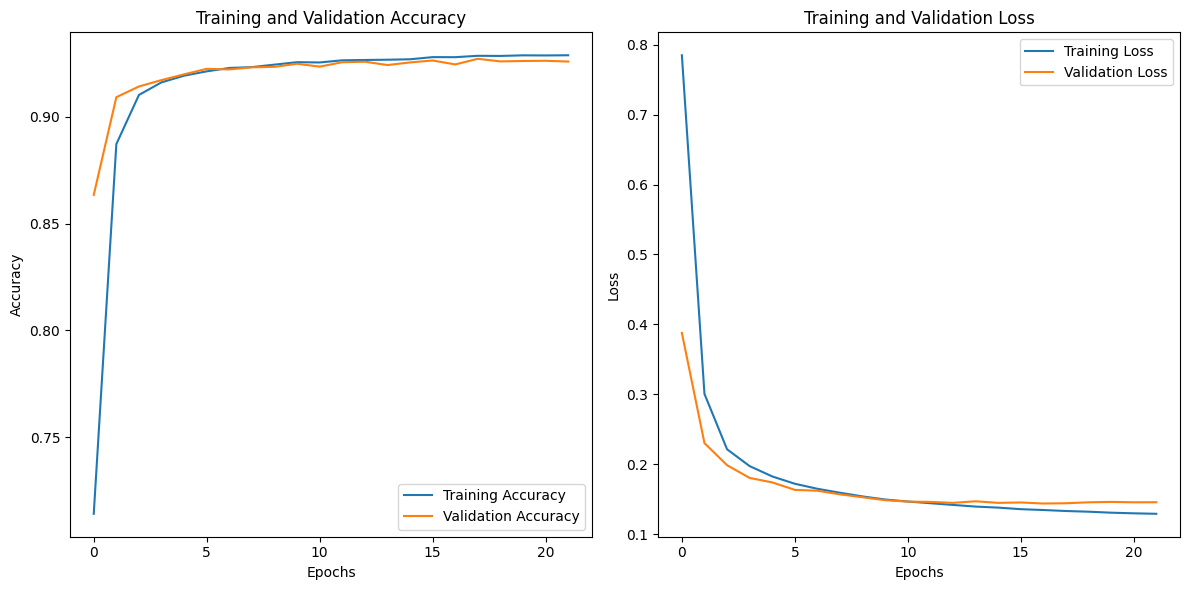

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     12099
           1       0.96      0.92      0.94     14078
           2       0.79      0.89      0.84      3449
           3       0.94      0.92      0.93      5723
           4       0.84      0.96      0.90      4766
           5       0.87      0.71      0.78      1496

    accuracy                           0.92     41611
   macro avg       0.89      0.89      0.89     41611
weighted avg       0.93      0.92      0.92     41611


Metrics:

Train Loss: 0.12919165194034576
Val Loss: 0.14571449160575867
Test Loss: 0.14479058980941772
AUC: 0.9964107188066151
Accuracy: 0.9244430661201477
Precision: 0.9276064645036916
Recall: 0.9244430559227127
F1-Score: 0.9248318856783193

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


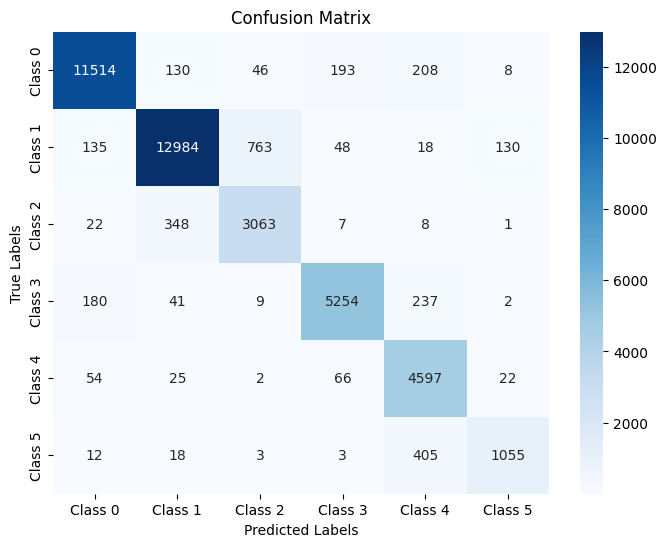


Model saved as 'word2vec_gru_model_3.h5'



In [ ]:
word2vec_gru_model_3, word2vec_gru_metrics_3, word2vec_gru_history_3 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="gru"
)

word2vec_gru_model_3.save('word2vec_gru_model_3.h5')
print("\nModel saved as 'word2vec_gru_model_3.h5'\n")

### 4. Batch 16 & LR 0.01

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 106s 5ms/step - accuracy: 0.3349 - loss: 1.5775 - val_accuracy: 0.3383 - val_loss: 1.5740
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 103s 5ms/step - accuracy: 0.3383 - loss: 1.5725 - val_accuracy: 0.3383 - val_loss: 1.5733
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 103s 5ms/step - accuracy: 0.3370 - loss: 1.5756 - val_accuracy: 0.3383 - val_loss: 1.5746
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 103s 5ms/step - accuracy: 0.3379 - loss: 1.5728 - val_accuracy: 0.3383 - val_loss: 1.5732
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 103s 5ms/step - accuracy: 0.3373 - loss: 1.5745 - val_accuracy: 0.3383 - val_loss: 1.5731
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 103s 5ms/step - accuracy: 0.3364 - loss: 1.5747 - val_accuracy: 0.3383 - val_loss: 1.5742
Epoch 7/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 103s 5ms/step - accuracy: 0.3371 - loss: 1.5753 - val_accuracy: 0.3383 - val_loss: 1.5753
Epoch 8/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 103s 5ms/s

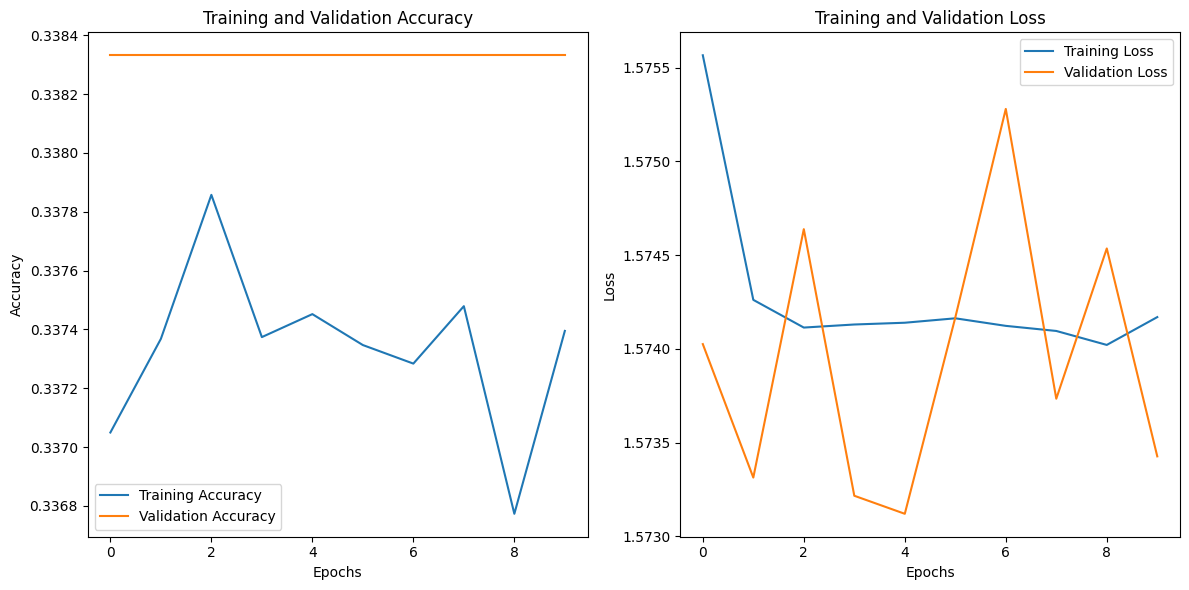

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12099
           1       0.34      1.00      0.51     14078
           2       0.00      0.00      0.00      3449
           3       0.00      0.00      0.00      5723
           4       0.00      0.00      0.00      4766
           5       0.00      0.00      0.00      1496

    accuracy                           0.34     41611
   macro avg       0.06      0.17      0.08     41611
weighted avg       0.11      0.34      0.17     41611


Metrics:

Train Loss: 1.5741697549819946
Val Loss: 1.5734270811080933
Test Loss: 1.5730963945388794
AUC: 0.5
Accuracy: 0.33832401037216187
Precision: 0.11446312956140597
Recall: 0.33832400086515585
F1-Score: 0.171054437471661

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


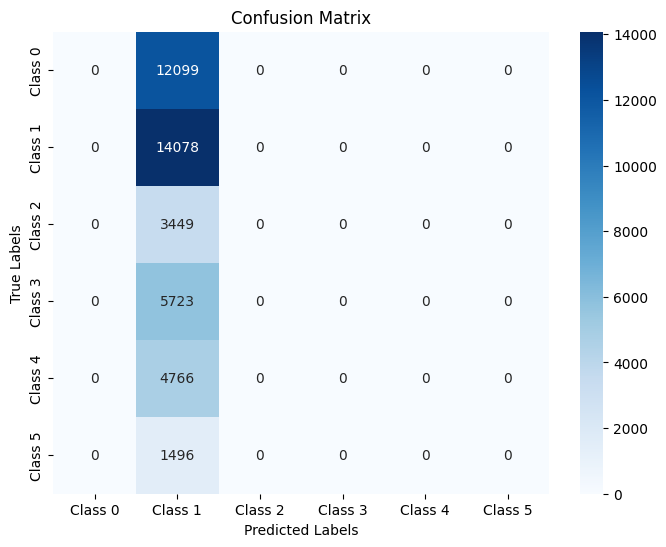


Model saved as 'word2vec_gru_model_4.h5'



In [ ]:
word2vec_gru_model_4, word2vec_gru_metrics_4, word2vec_gru_history_4 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="gru"
)

word2vec_gru_model_4.save('word2vec_gru_model_4.h5')
print("\nModel saved as 'word2vec_gru_model_4.h5'\n")

### 5. Batch 16 & LR 0.001

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 106s 5ms/step - accuracy: 0.3355 - loss: 1.5811 - val_accuracy: 0.3383 - val_loss: 1.5737
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 103s 5ms/step - accuracy: 0.3391 - loss: 1.5732 - val_accuracy: 0.3383 - val_loss: 1.5730
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 103s 5ms/step - accuracy: 0.3391 - loss: 1.5723 - val_accuracy: 0.3383 - val_loss: 1.5729
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 103s 5ms/step - accuracy: 0.3381 - loss: 1.5738 - val_accuracy: 0.3383 - val_loss: 1.5730
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 103s 5ms/step - accuracy: 0.3368 - loss: 1.5735 - val_accuracy: 0.3383 - val_loss: 1.5731
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 102s 5ms/step - accuracy: 0.3393 - loss: 1.5717 - val_accuracy: 0.3383 - val_loss: 1.5730
Epoch 7/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 102s 5ms/step - accuracy: 0.3393 - loss: 1.5723 - val_accuracy: 0.3383 - val_loss: 1.5730
Epoch 8/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 103s 5ms/s

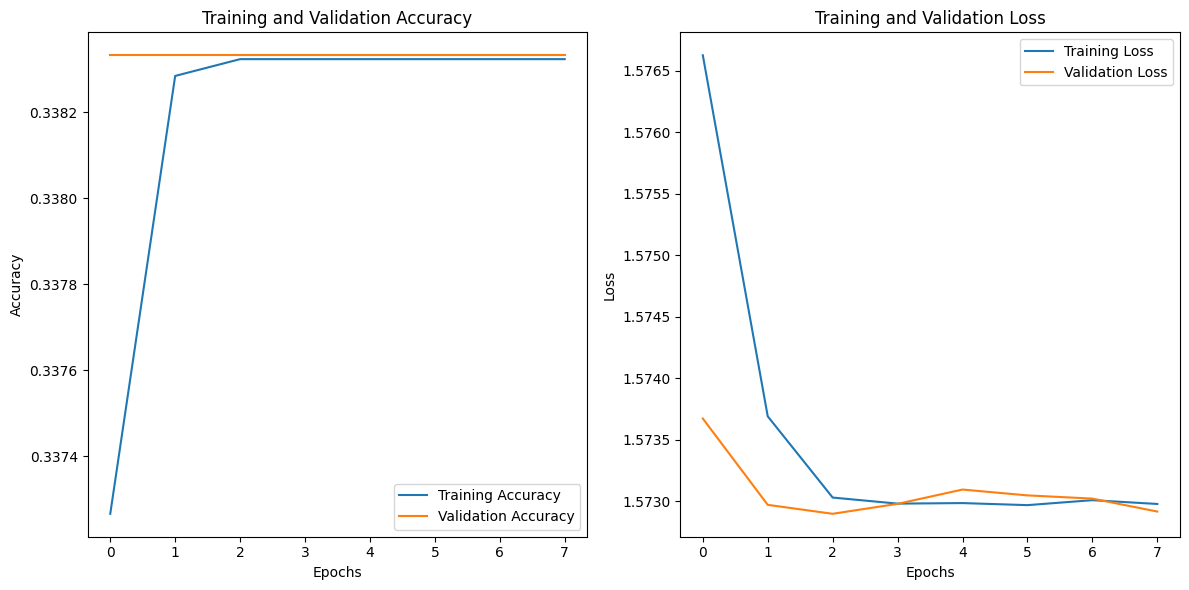

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12099
           1       0.34      1.00      0.51     14078
           2       0.00      0.00      0.00      3449
           3       0.00      0.00      0.00      5723
           4       0.00      0.00      0.00      4766
           5       0.00      0.00      0.00      1496

    accuracy                           0.34     41611
   macro avg       0.06      0.17      0.08     41611
weighted avg       0.11      0.34      0.17     41611


Metrics:

Train Loss: 1.572977066040039
Val Loss: 1.5729153156280518
Test Loss: 1.5728752613067627
AUC: 0.5
Accuracy: 0.33832401037216187
Precision: 0.11446312956140597
Recall: 0.33832400086515585
F1-Score: 0.171054437471661

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


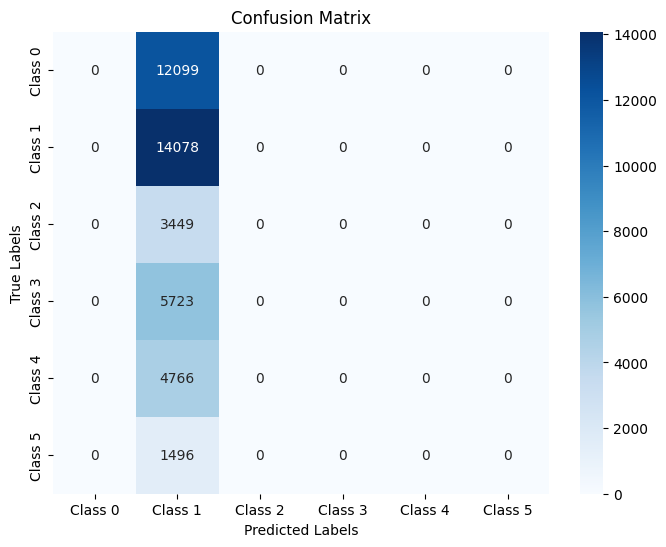


Model saved as 'word2vec_gru_model_5.h5'



In [ ]:
word2vec_gru_model_5, word2vec_gru_metrics_5, word2vec_gru_history_5 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="gru"
)

word2vec_gru_model_5.save('word2vec_gru_model_5.h5')
print("\nModel saved as 'word2vec_gru_model_5.h5'\n")

### 6. Batch 16 & LR 0.0001

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 107s 5ms/step - accuracy: 0.5434 - loss: 1.1751 - val_accuracy: 0.8481 - val_loss: 0.4791
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 103s 5ms/step - accuracy: 0.8605 - loss: 0.4417 - val_accuracy: 0.8973 - val_loss: 0.2845
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 104s 5ms/step - accuracy: 0.8978 - loss: 0.2911 - val_accuracy: 0.9062 - val_loss: 0.2333
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 104s 5ms/step - accuracy: 0.9057 - loss: 0.2430 - val_accuracy: 0.9106 - val_loss: 0.2141
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 104s 5ms/step - accuracy: 0.9100 - loss: 0.2225 - val_accuracy: 0.9136 - val_loss: 0.1975
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 104s 5ms/step - accuracy: 0.9131 - loss: 0.2044 - val_accuracy: 0.9161 - val_loss: 0.1871
Epoch 7/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 104s 5ms/step - accuracy: 0.9163 - loss: 0.1922 - val_accuracy: 0.9182 - val_loss: 0.1782
Epoch 8/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 104s 5ms/s

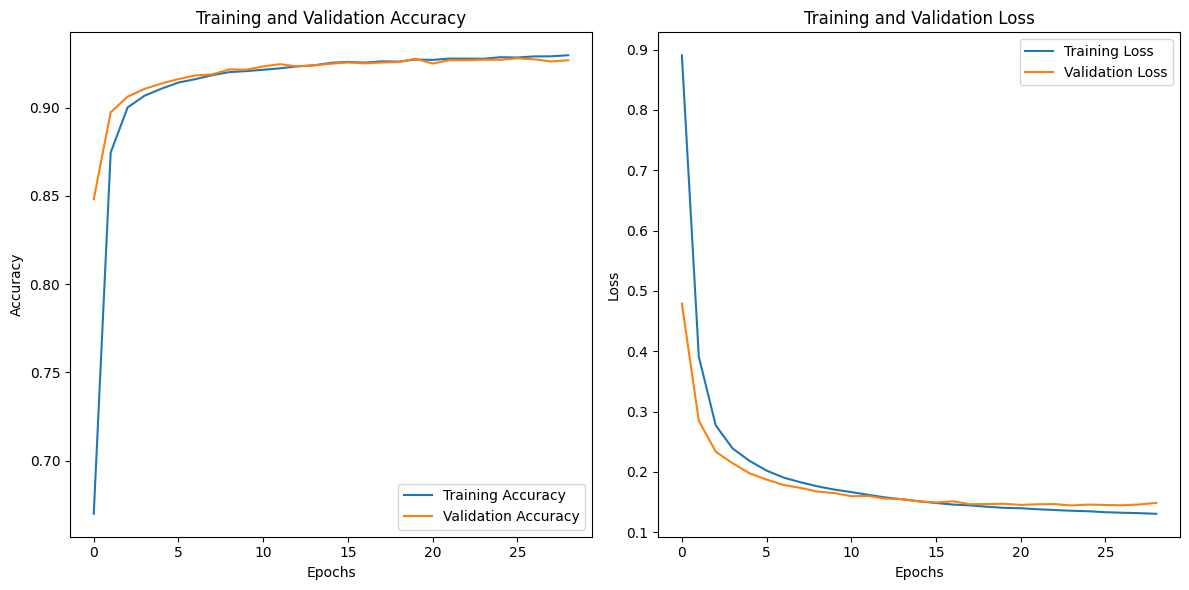

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     12099
           1       0.96      0.92      0.94     14078
           2       0.77      0.93      0.84      3449
           3       0.91      0.96      0.93      5723
           4       0.96      0.82      0.88      4766
           5       0.76      0.90      0.82      1496

    accuracy                           0.93     41611
   macro avg       0.89      0.91      0.90     41611
weighted avg       0.93      0.93      0.93     41611


Metrics:

Train Loss: 0.13040229678153992
Val Loss: 0.14851360023021698
Test Loss: 0.1492895632982254
AUC: 0.9961702651307727
Accuracy: 0.9254283905029297
Precision: 0.9306127596169502
Recall: 0.9254283723054
F1-Score: 0.9261889599837895

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


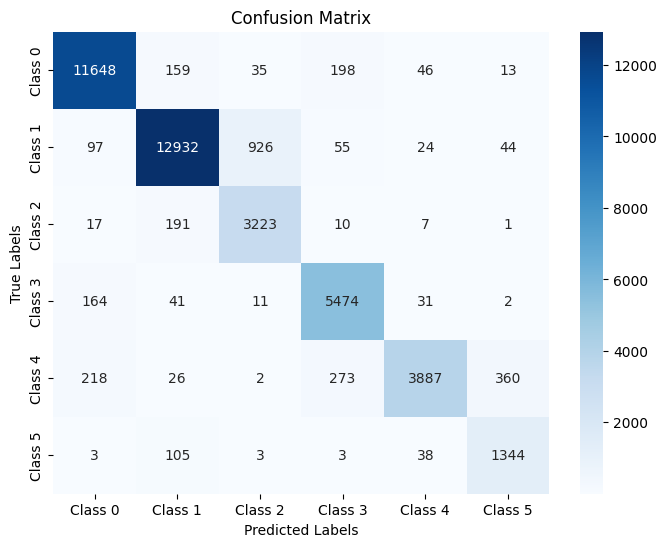


Model saved as 'word2vec_gru_model_6.h5'



In [ ]:
word2vec_gru_model_6, word2vec_gru_metrics_6, word2vec_gru_history_6 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="gru"
)

word2vec_gru_model_6.save('word2vec_gru_model_6.h5')
print("\nModel saved as 'word2vec_gru_model_6.h5'\n")

### 7. Batch 32 & LR 0.01

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 60s 6ms/step - accuracy: 0.3353 - loss: 1.5764 - val_accuracy: 0.3383 - val_loss: 1.5730
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.3388 - loss: 1.5727 - val_accuracy: 0.3383 - val_loss: 1.5736
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.3382 - loss: 1.5723 - val_accuracy: 0.3383 - val_loss: 1.5734
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.3381 - loss: 1.5741 - val_accuracy: 0.3383 - val_loss: 1.5735
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.3389 - loss: 1.5736 - val_accuracy: 0.3383 - val_loss: 1.5733
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - accuracy: 0.3386 - loss: 1.5725 - val_accuracy: 0.3383 - val_loss: 1.5732
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.

Training History:



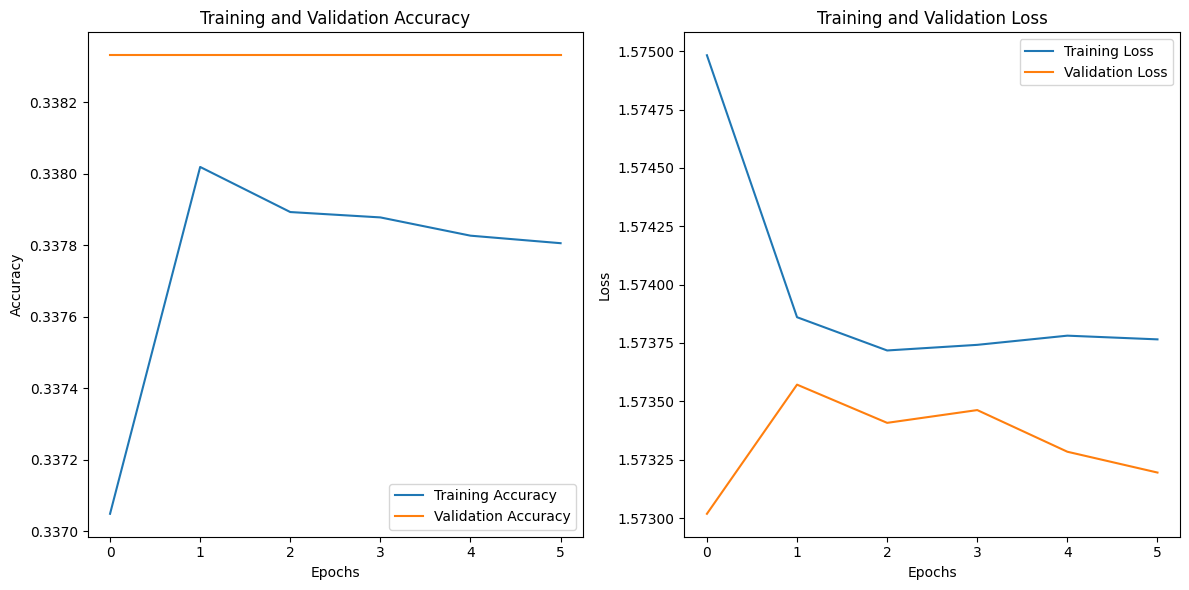

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12099
           1       0.34      1.00      0.51     14078
           2       0.00      0.00      0.00      3449
           3       0.00      0.00      0.00      5723
           4       0.00      0.00      0.00      4766
           5       0.00      0.00      0.00      1496

    accuracy                           0.34     41611
   macro avg       0.06      0.17      0.08     41611
weighted avg       0.11      0.34      0.17     41611


Metrics:

Train Loss: 1.573765516281128
Val Loss: 1.573194980621338
Test Loss: 1.5729979276657104
AUC: 0.5
Accuracy: 0.33832401037216187
Precision: 0.11446312956140597
Recall: 0.33832400086515585
F1-Score: 0.171054437471661

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


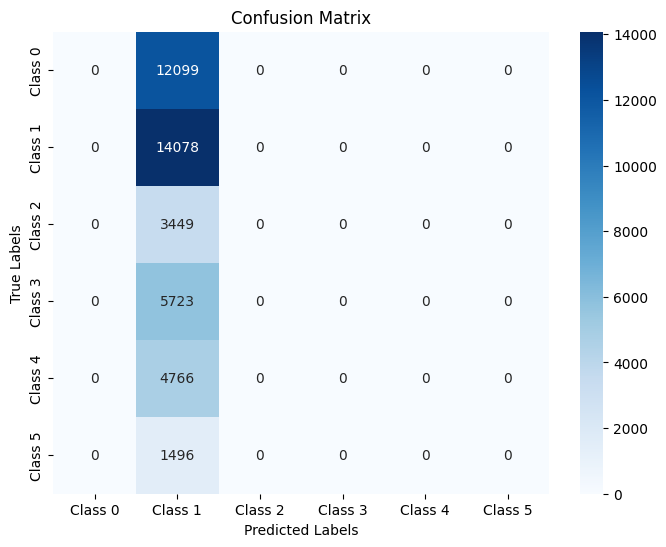


Model saved as 'word2vec_gru_model_7.h5'



In [ ]:
word2vec_gru_model_7, word2vec_gru_metrics_7, word2vec_gru_history_7 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="gru"
)

word2vec_gru_model_7.save('word2vec_gru_model_7.h5')
print("\nModel saved as 'word2vec_gru_model_7.h5'\n")

### 8. Batch 32 & LR 0.001

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 60s 6ms/step - accuracy: 0.3350 - loss: 1.5814 - val_accuracy: 0.3383 - val_loss: 1.5732
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.3373 - loss: 1.5762 - val_accuracy: 0.3383 - val_loss: 1.5736
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.3388 - loss: 1.5713 - val_accuracy: 0.3383 - val_loss: 1.5730
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - accuracy: 0.3376 - loss: 1.5740 - val_accuracy: 0.3383 - val_loss: 1.5730
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - accuracy: 0.3390 - loss: 1.5737 - val_accuracy: 0.3383 - val_loss: 1.5729
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.3391 - loss: 1.5728 - val_accuracy: 0.3383 - val_loss: 1.5729
Epoch 7/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - accuracy: 0.3374 - loss: 1.5727 - val_accuracy: 0.3383 - val_loss: 1.5729
Epoch 8/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - ac

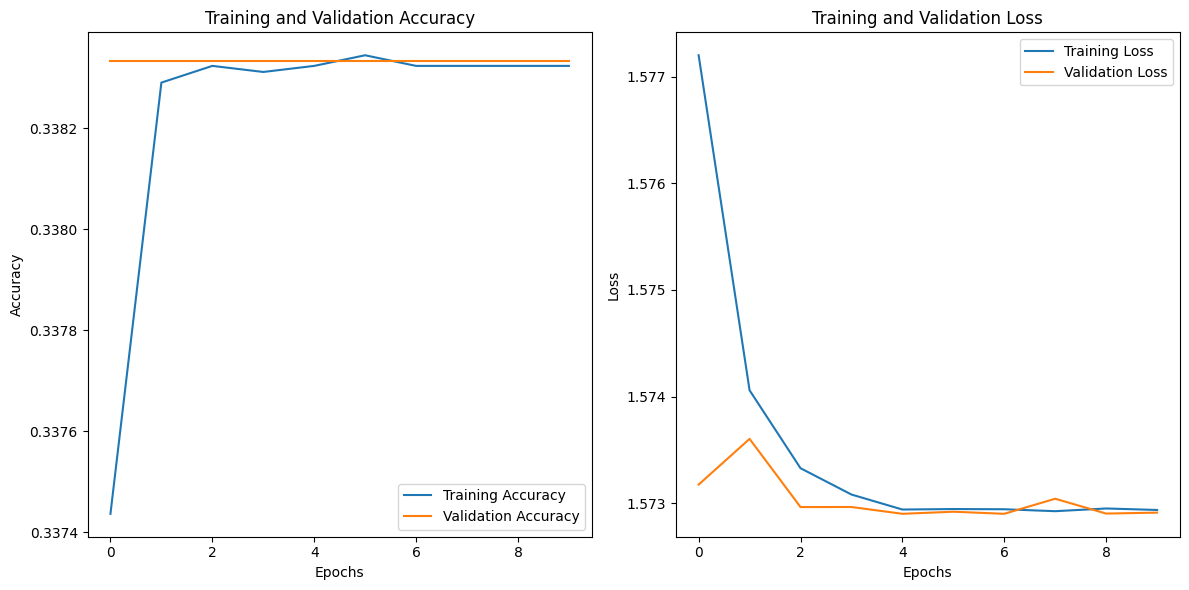

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12099
           1       0.34      1.00      0.51     14078
           2       0.00      0.00      0.00      3449
           3       0.00      0.00      0.00      5723
           4       0.00      0.00      0.00      4766
           5       0.00      0.00      0.00      1496

    accuracy                           0.34     41611
   macro avg       0.06      0.17      0.08     41611
weighted avg       0.11      0.34      0.17     41611


Metrics:

Train Loss: 1.5729358196258545
Val Loss: 1.5729109048843384
Test Loss: 1.5728790760040283
AUC: 0.5
Accuracy: 0.33832401037216187
Precision: 0.11446312956140597
Recall: 0.33832400086515585
F1-Score: 0.171054437471661

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


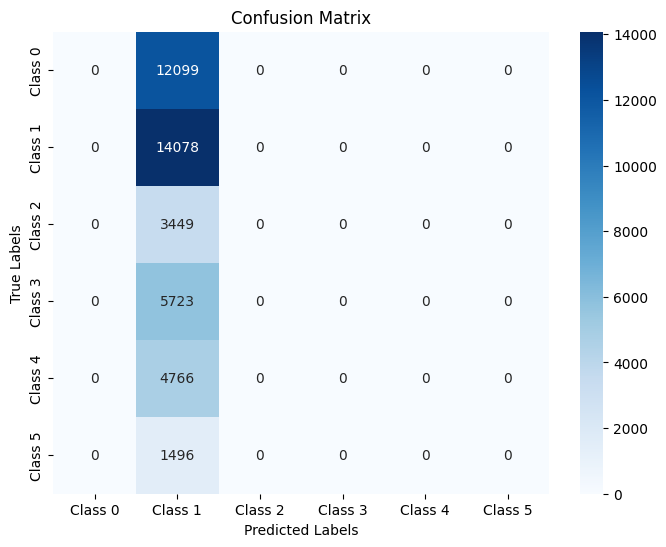


Model saved as 'word2vec_gru_model_8.h5'



In [ ]:
word2vec_gru_model_8, word2vec_gru_metrics_8, word2vec_gru_history_8 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="gru"
)

word2vec_gru_model_8.save('word2vec_gru_model_8.h5')
print("\nModel saved as 'word2vec_gru_model_8.h5'\n")

### 9. Batch 32 & LR 0.0001

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 59s 6ms/step - accuracy: 0.4918 - loss: 1.2875 - val_accuracy: 0.7327 - val_loss: 0.7144
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - accuracy: 0.7878 - loss: 0.6234 - val_accuracy: 0.8812 - val_loss: 0.3676
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - accuracy: 0.8851 - loss: 0.3575 - val_accuracy: 0.9035 - val_loss: 0.2653
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - accuracy: 0.9023 - loss: 0.2680 - val_accuracy: 0.9064 - val_loss: 0.2264
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - accuracy: 0.9083 - loss: 0.2357 - val_accuracy: 0.9122 - val_loss: 0.2090
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - accuracy: 0.9128 - loss: 0.2175 - val_accuracy: 0.9160 - val_loss: 0.2002
Epoch 7/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - accuracy: 0.9158 - loss: 0.2014 - val_accuracy: 0.9159 - val_loss: 0.1862
Epoch 8/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - ac

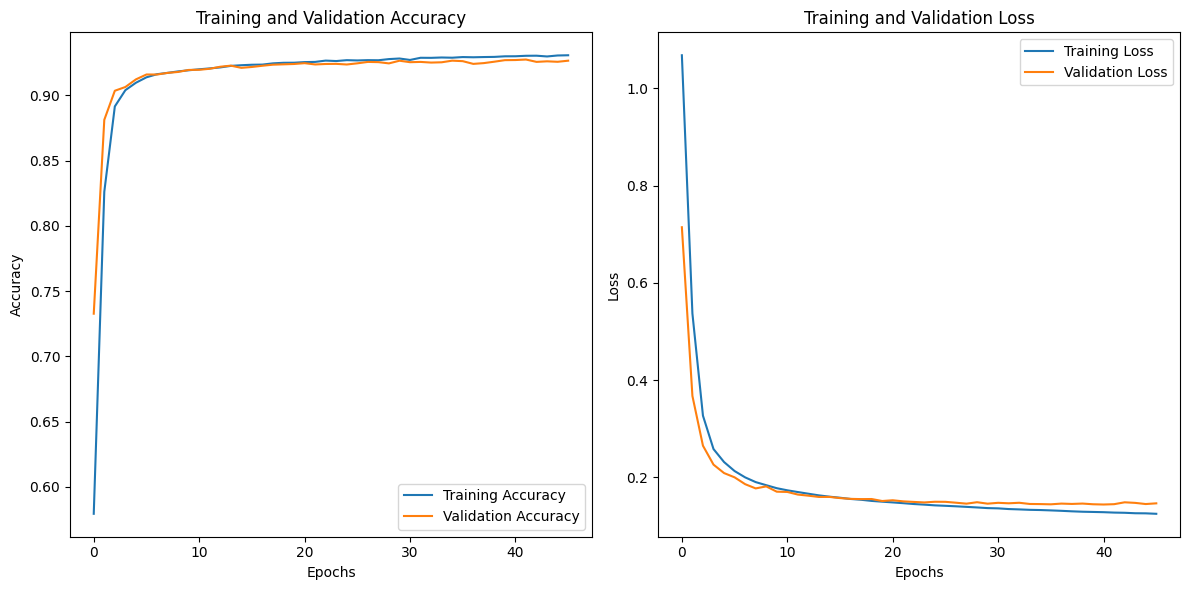

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     12099
           1       0.92      0.96      0.94     14078
           2       0.89      0.74      0.81      3449
           3       0.96      0.90      0.93      5723
           4       0.86      0.93      0.89      4766
           5       0.92      0.65      0.76      1496

    accuracy                           0.92     41611
   macro avg       0.92      0.86      0.88     41611
weighted avg       0.92      0.92      0.92     41611


Metrics:

Train Loss: 0.12527349591255188
Val Loss: 0.14676299691200256
Test Loss: 0.1455335170030594
AUC: 0.9963307526416627
Accuracy: 0.9242027401924133
Precision: 0.9244285158268385
Recall: 0.9242027348537646
F1-Score: 0.9224828085519351

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


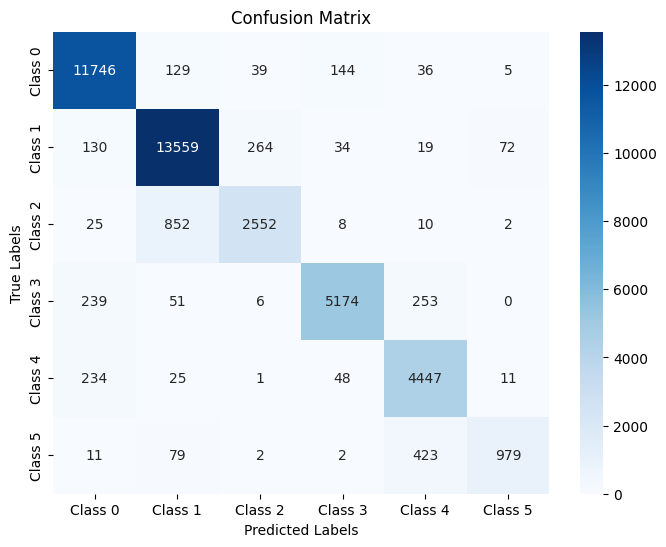


Model saved as 'word2vec_gru_model_9.h5'



In [ ]:
word2vec_gru_model_9, word2vec_gru_metrics_9, word2vec_gru_history_9 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="gru"
)

word2vec_gru_model_9.save('word2vec_gru_model_9.h5')
print("\nModel saved as 'word2vec_gru_model_9.h5'\n")

## Bi-GRU

### 1. Batch 8 & LR 0.01

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 309s 7ms/step - accuracy: 0.7648 - loss: 0.6933 - val_accuracy: 0.8709 - val_loss: 0.3899
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 305s 7ms/step - accuracy: 0.8088 - loss: 0.5658 - val_accuracy: 0.8714 - val_loss: 0.4096
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 306s 7ms/step - accuracy: 0.8110 - loss: 0.5538 - val_accuracy: 0.8676 - val_loss: 0.4413
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 307s 7ms/step - accuracy: 0.8112 - loss: 0.5680 - val_accuracy: 0.8385 - val_loss: 0.4451
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 307s 7ms/step - accuracy: 0.8096 - loss: 0.5658 - val_accuracy: 0.8683 - val_loss: 0.3964
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 307s 7ms/step - accuracy: 0.8067 - loss: 0.5781 - val_accuracy: 0.8614 - val_loss: 0.4411
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.

Training History:



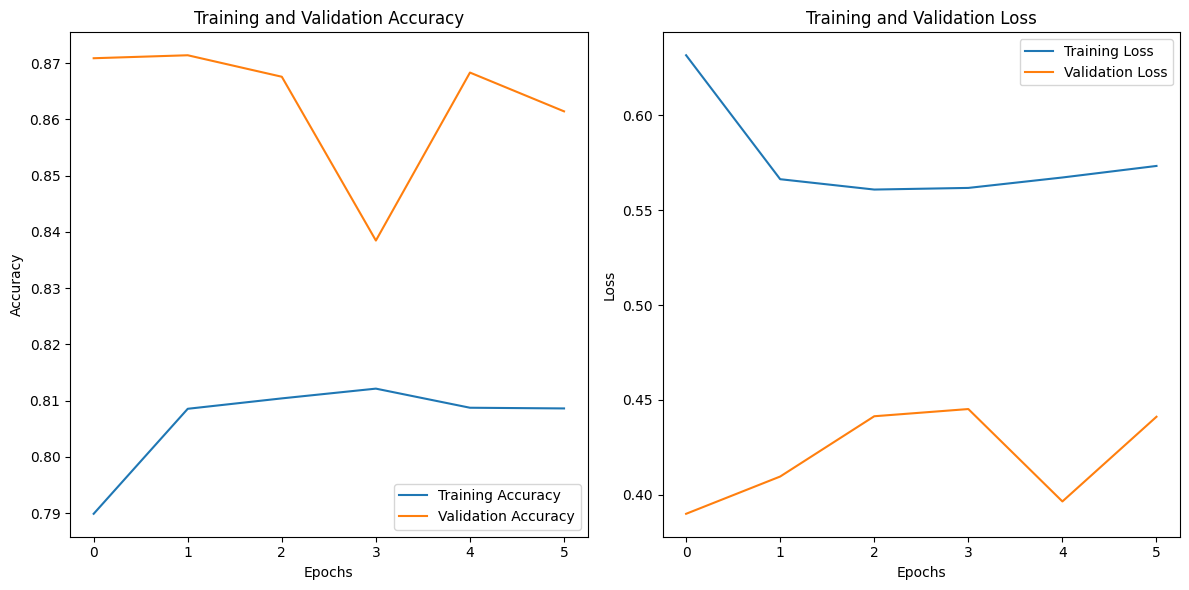

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.90      0.92     12099
           1       0.81      0.96      0.88     14078
           2       0.87      0.54      0.67      3449
           3       0.92      0.88      0.90      5723
           4       0.94      0.79      0.86      4766
           5       0.76      0.77      0.77      1496

    accuracy                           0.87     41611
   macro avg       0.87      0.81      0.83     41611
weighted avg       0.88      0.87      0.87     41611


Metrics:

Train Loss: 0.5733760595321655
Val Loss: 0.4410821795463562
Test Loss: 0.37680885195732117
AUC: 0.9845243237185505
Accuracy: 0.8722453117370605
Precision: 0.8785414445388605
Recall: 0.8722453197471822
F1-Score: 0.8690588991269895

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


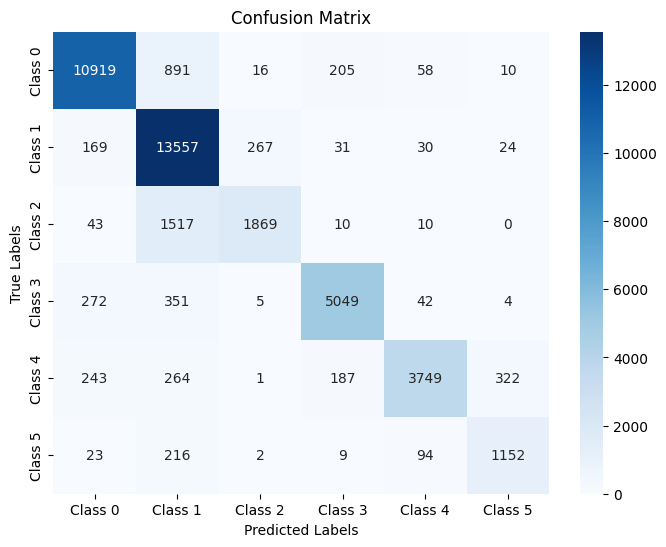


Model saved as 'word2vec_bigru_model_1.h5'



In [ ]:
word2vec_bigru_model_1, word2vec_bigru_metrics_1, word2vec_bigru_history_1 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="bigru"
)

word2vec_bigru_model_1.save('word2vec_bigru_model_1.h5')
print("\nModel saved as 'word2vec_bigru_model_1.h5'\n")

### 2. Batch 8 & LR 0.001

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 314s 7ms/step - accuracy: 0.8658 - loss: 0.3526 - val_accuracy: 0.9199 - val_loss: 0.1621
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 308s 7ms/step - accuracy: 0.9189 - loss: 0.1769 - val_accuracy: 0.9211 - val_loss: 0.1621
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 307s 7ms/step - accuracy: 0.9207 - loss: 0.1712 - val_accuracy: 0.9211 - val_loss: 0.1609
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 307s 7ms/step - accuracy: 0.9209 - loss: 0.1665 - val_accuracy: 0.9225 - val_loss: 0.1592
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 307s 7ms/step - accuracy: 0.9217 - loss: 0.1657 - val_accuracy: 0.9216 - val_loss: 0.1661
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 307s 7ms/step - accuracy: 0.9215 - loss: 0.1667 - val_accuracy: 0.9247 - val_loss: 0.1620
Epoch 7/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 306s 7ms/step - accuracy: 0.9214 - loss: 0.1693 - val_accuracy: 0.9230 - val_loss: 0.1684
Epoch 8/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 307s 7ms/s

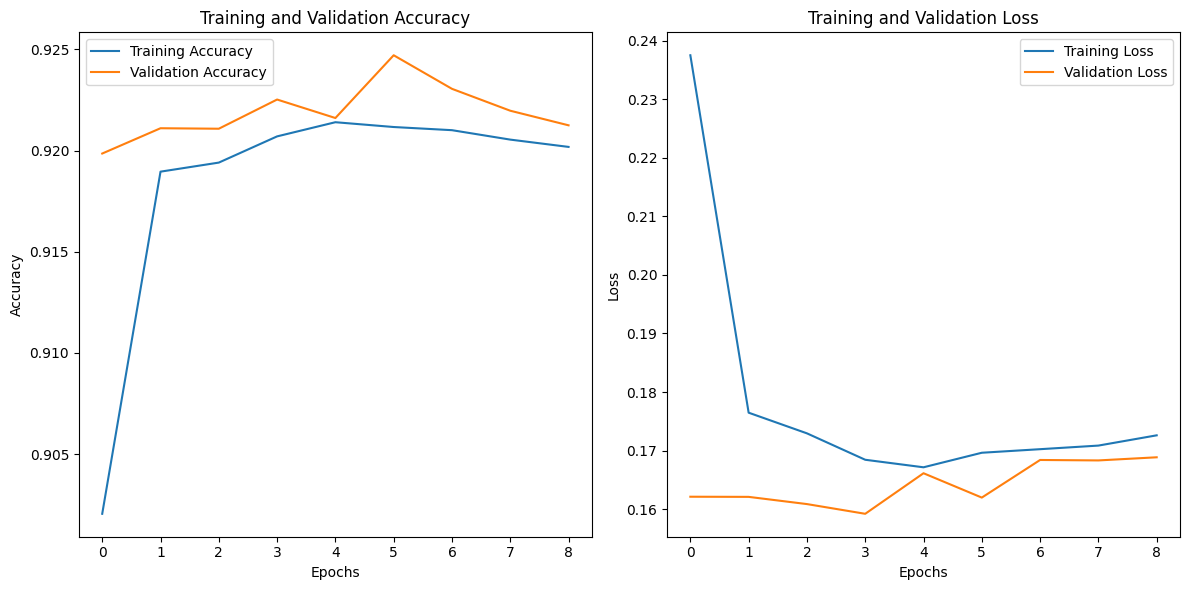

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     12099
           1       0.93      0.94      0.94     14078
           2       0.82      0.80      0.81      3449
           3       0.93      0.93      0.93      5723
           4       0.92      0.86      0.89      4766
           5       0.77      0.85      0.81      1496

    accuracy                           0.92     41611
   macro avg       0.89      0.89      0.89     41611
weighted avg       0.92      0.92      0.92     41611


Metrics:

Train Loss: 0.17260588705539703
Val Loss: 0.1688539832830429
Test Loss: 0.16309505701065063
AUC: 0.9959987237654652
Accuracy: 0.9216793775558472
Precision: 0.921907594220187
Recall: 0.9216793636298094
F1-Score: 0.9216110759801202

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


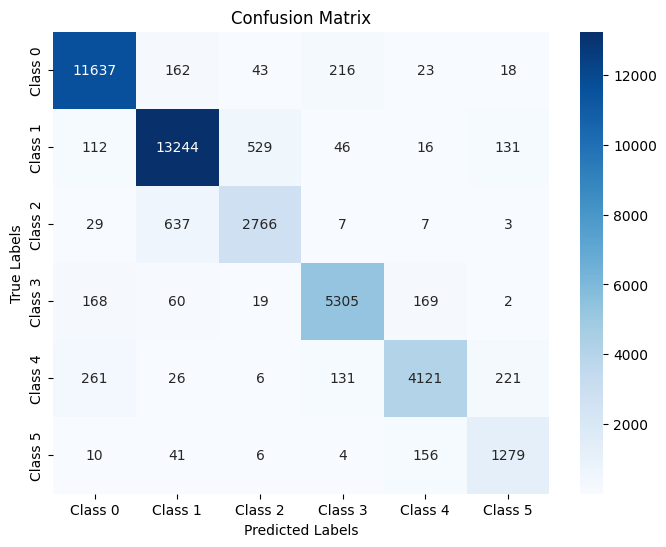


Model saved as 'word2vec_bigru_model_2.h5'



In [ ]:
word2vec_bigru_model_2, word2vec_bigru_metrics_2, word2vec_bigru_history_2 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="bigru"
)

word2vec_bigru_model_2.save('word2vec_bigru_model_2.h5')
print("\nModel saved as 'word2vec_bigru_model_2.h5'\n")

### 3. Batch 8 & LR 0.0001

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 315s 8ms/step - accuracy: 0.7308 - loss: 0.7167 - val_accuracy: 0.9095 - val_loss: 0.2163
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 310s 7ms/step - accuracy: 0.9108 - loss: 0.2167 - val_accuracy: 0.9169 - val_loss: 0.1774
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 310s 7ms/step - accuracy: 0.9182 - loss: 0.1833 - val_accuracy: 0.9205 - val_loss: 0.1631
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 309s 7ms/step - accuracy: 0.9209 - loss: 0.1673 - val_accuracy: 0.9216 - val_loss: 0.1576
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 311s 7ms/step - accuracy: 0.9223 - loss: 0.1574 - val_accuracy: 0.9208 - val_loss: 0.1549
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 309s 7ms/step - accuracy: 0.9239 - loss: 0.1522 - val_accuracy: 0.9213 - val_loss: 0.1535
Epoch 7/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 308s 7ms/step - accuracy: 0.9256 - loss: 0.1444 - val_accuracy: 0.9236 - val_loss: 0.1487
Epoch 8/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 309s 7ms/s

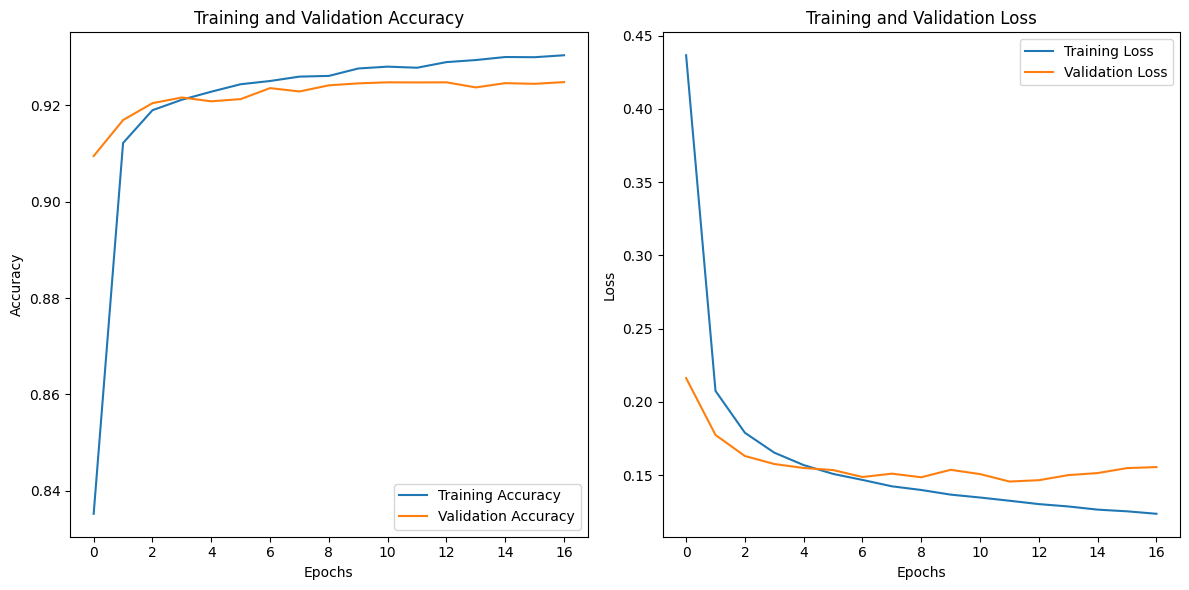

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.94      0.96     12099
           1       0.94      0.94      0.94     14078
           2       0.85      0.78      0.81      3449
           3       0.91      0.95      0.93      5723
           4       0.87      0.90      0.89      4766
           5       0.78      0.79      0.79      1496

    accuracy                           0.92     41611
   macro avg       0.89      0.89      0.89     41611
weighted avg       0.92      0.92      0.92     41611


Metrics:

Train Loss: 0.12363201379776001
Val Loss: 0.15551432967185974
Test Loss: 0.1468583643436432
AUC: 0.9963492795580188
Accuracy: 0.9223042130470276
Precision: 0.9225975864197968
Recall: 0.9223041984090745
F1-Score: 0.9221689621232789

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


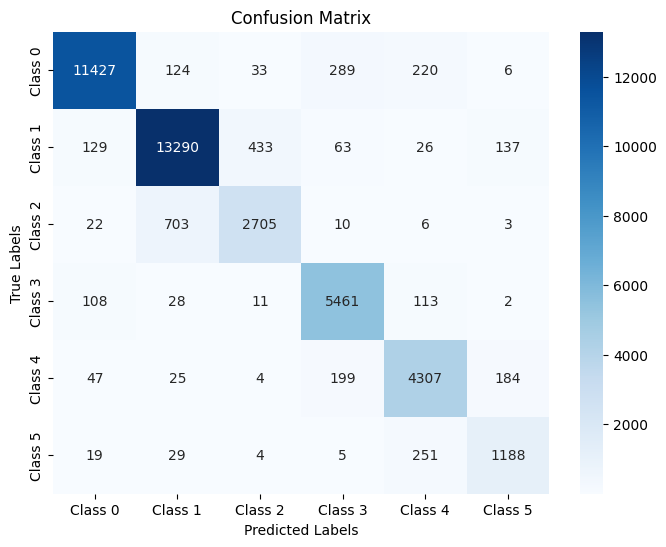


Model saved as 'word2vec_bigru_model_3.h5'



In [ ]:
word2vec_bigru_model_3, word2vec_bigru_metrics_3, word2vec_bigru_history_3 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="bigru"
)

word2vec_bigru_model_3.save('word2vec_bigru_model_3.h5')
print("\nModel saved as 'word2vec_bigru_model_3.h5'\n")

### 4. Batch 16 & LR 0.01

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 158s 8ms/step - accuracy: 0.8364 - loss: 0.4783 - val_accuracy: 0.8933 - val_loss: 0.3184
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 154s 7ms/step - accuracy: 0.8597 - loss: 0.4232 - val_accuracy: 0.8940 - val_loss: 0.2900
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 156s 7ms/step - accuracy: 0.8610 - loss: 0.4146 - val_accuracy: 0.8946 - val_loss: 0.3136
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 155s 7ms/step - accuracy: 0.8632 - loss: 0.4020 - val_accuracy: 0.8949 - val_loss: 0.3029
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 155s 7ms/step - accuracy: 0.8615 - loss: 0.4102 - val_accuracy: 0.8888 - val_loss: 0.3277
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 154s 7ms/step - accuracy: 0.8601 - loss: 0.4122 - val_accuracy: 0.8949 - val_loss: 0.2834
Epoch 7/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 155s 7ms/step - accuracy: 0.8623 - loss: 0.4049 - val_accuracy: 0.8998 - val_loss: 0.2823
Epoch 8/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 154s 7ms/s

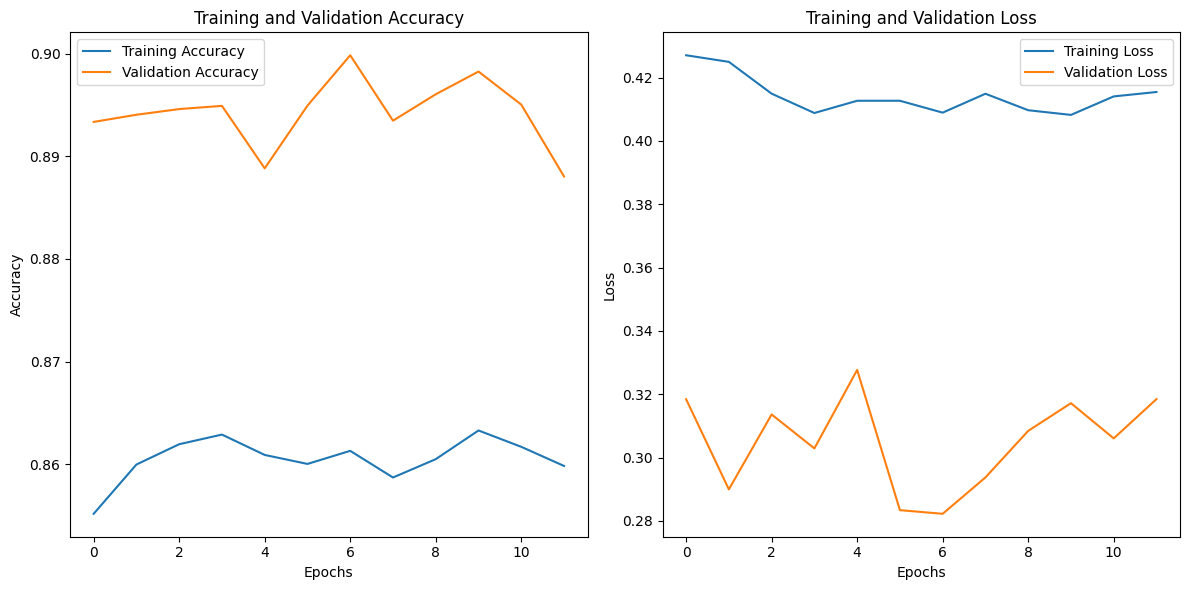

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     12099
           1       0.89      0.96      0.93     14078
           2       0.93      0.62      0.74      3449
           3       0.89      0.92      0.91      5723
           4       0.89      0.85      0.87      4766
           5       0.97      0.54      0.70      1496

    accuracy                           0.90     41611
   macro avg       0.91      0.81      0.84     41611
weighted avg       0.90      0.90      0.89     41611


Metrics:

Train Loss: 0.4154324531555176
Val Loss: 0.3184767961502075
Test Loss: 0.2904667556285858
AUC: 0.9903358488512329
Accuracy: 0.8973107933998108
Precision: 0.8994788970633228
Recall: 0.8973108072384706
F1-Score: 0.8928101467223309

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


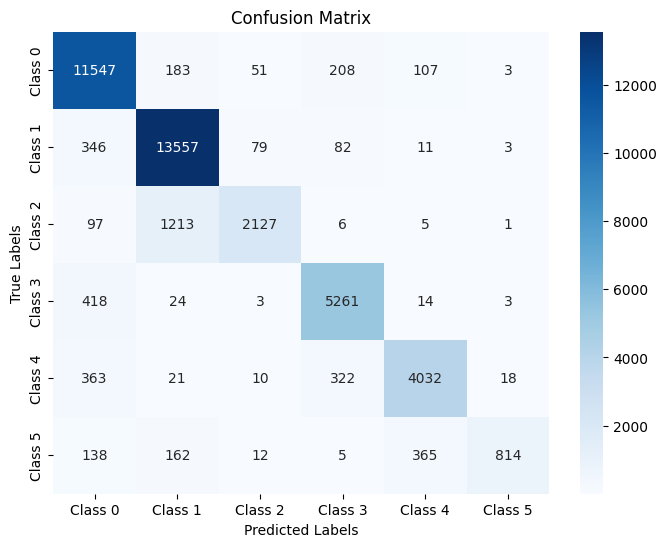


Model saved as 'word2vec_bigru_model_4.h5'



In [ ]:
word2vec_bigru_model_4, word2vec_bigru_metrics_4, word2vec_bigru_history_4 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="bigru"
)

word2vec_bigru_model_4.save('word2vec_bigru_model_4.h5')
print("\nModel saved as 'word2vec_bigru_model_4.h5'\n")

### 5. Batch 16 & LR 0.001

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 160s 8ms/step - accuracy: 0.8557 - loss: 0.3760 - val_accuracy: 0.9199 - val_loss: 0.1640
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 155s 7ms/step - accuracy: 0.9201 - loss: 0.1710 - val_accuracy: 0.9225 - val_loss: 0.1544
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 155s 7ms/step - accuracy: 0.9221 - loss: 0.1592 - val_accuracy: 0.9222 - val_loss: 0.1543
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 155s 7ms/step - accuracy: 0.9229 - loss: 0.1524 - val_accuracy: 0.9254 - val_loss: 0.1521
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 156s 7ms/step - accuracy: 0.9240 - loss: 0.1480 - val_accuracy: 0.9261 - val_loss: 0.1460
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 156s 7ms/step - accuracy: 0.9254 - loss: 0.1459 - val_accuracy: 0.9229 - val_loss: 0.1667
Epoch 7/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 156s 7ms/step - accuracy: 0.9253 - loss: 0.1450 - val_accuracy: 0.9258 - val_loss: 0.1533
Epoch 8/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 155s 7ms/s

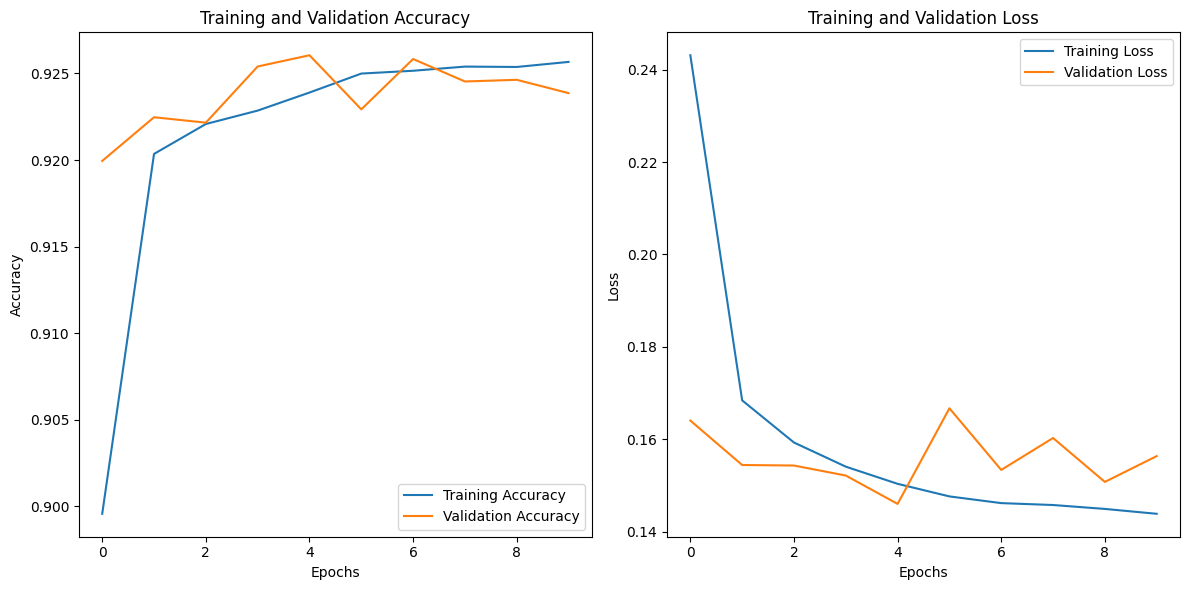

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     12099
           1       0.97      0.91      0.94     14078
           2       0.78      0.91      0.84      3449
           3       0.91      0.96      0.93      5723
           4       0.92      0.86      0.89      4766
           5       0.81      0.79      0.80      1496

    accuracy                           0.92     41611
   macro avg       0.89      0.90      0.89     41611
weighted avg       0.93      0.92      0.92     41611


Metrics:

Train Loss: 0.14383767545223236
Val Loss: 0.15632523596286774
Test Loss: 0.14944694936275482
AUC: 0.9962681039610165
Accuracy: 0.923361599445343
Precision: 0.9260907956563559
Recall: 0.9233616111124462
F1-Score: 0.923818409737597

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


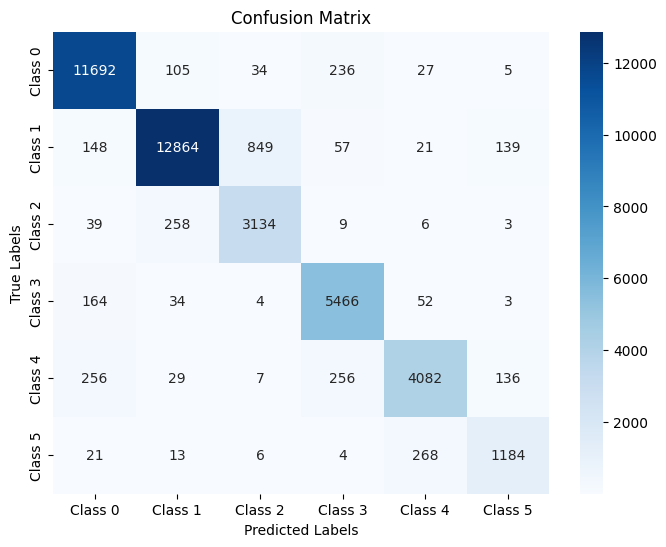


Model saved as 'word2vec_bigru_model_5.h5'



In [ ]:
word2vec_bigru_model_5, word2vec_bigru_metrics_5, word2vec_bigru_history_5 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="bigru"
)

word2vec_bigru_model_5.save('word2vec_bigru_model_5.h5')
print("\nModel saved as 'word2vec_bigru_model_5.h5'\n")

### 6. Batch 16 & LR 0.0001

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 149s 7ms/step - accuracy: 0.6850 - loss: 0.8372 - val_accuracy: 0.9030 - val_loss: 0.2327
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 143s 7ms/step - accuracy: 0.9061 - loss: 0.2366 - val_accuracy: 0.9149 - val_loss: 0.1905
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 143s 7ms/step - accuracy: 0.9154 - loss: 0.1927 - val_accuracy: 0.9170 - val_loss: 0.1753
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 144s 7ms/step - accuracy: 0.9204 - loss: 0.1748 - val_accuracy: 0.9205 - val_loss: 0.1629
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 143s 7ms/step - accuracy: 0.9219 - loss: 0.1640 - val_accuracy: 0.9233 - val_loss: 0.1576
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 144s 7ms/step - accuracy: 0.9227 - loss: 0.1574 - val_accuracy: 0.9209 - val_loss: 0.1540
Epoch 7/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 145s 7ms/step - accuracy: 0.9239 - loss: 0.1516 - val_accuracy: 0.9212 - val_loss: 0.1572
Epoch 8/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 144s 7ms/s

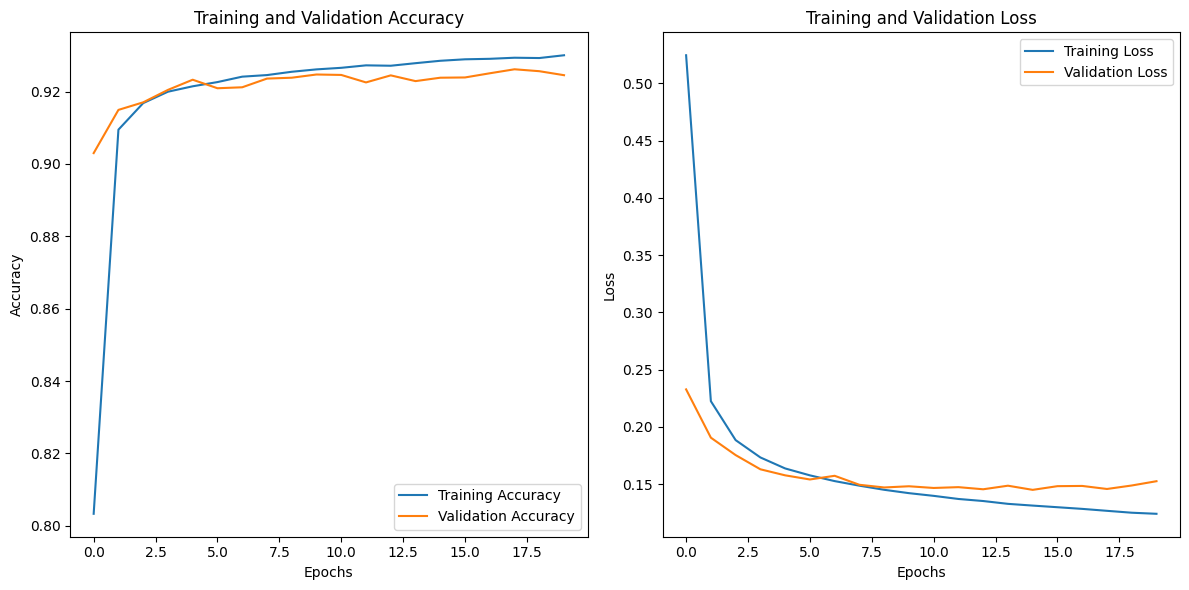

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     12099
           1       0.96      0.92      0.94     14078
           2       0.78      0.91      0.84      3449
           3       0.95      0.90      0.93      5723
           4       0.84      0.97      0.90      4766
           5       0.93      0.64      0.75      1496

    accuracy                           0.92     41611
   macro avg       0.90      0.88      0.89     41611
weighted avg       0.93      0.92      0.92     41611


Metrics:

Train Loss: 0.12402833998203278
Val Loss: 0.15249855816364288
Test Loss: 0.1475803405046463
AUC: 0.9964099479223191
Accuracy: 0.9233375787734985
Precision: 0.9278780565516572
Recall: 0.9233375790055515
F1-Score: 0.9233899386266583

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


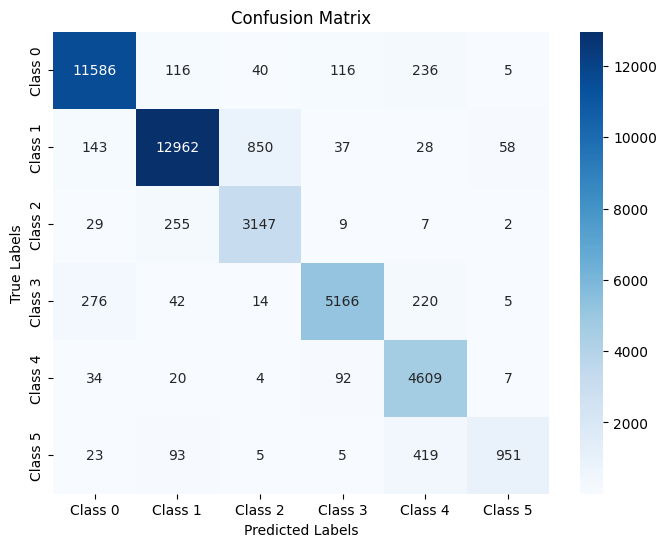


Model saved as 'word2vec_bigru_model_6.h5'



In [ ]:
word2vec_bigru_model_6, word2vec_bigru_metrics_6, word2vec_bigru_history_6 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="bigru"
)

word2vec_bigru_model_6.save('word2vec_bigru_model_6.h5')
print("\nModel saved as 'word2vec_bigru_model_6.h5'\n")

### 7. Batch 32 & LR 0.01

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - accuracy: 0.8562 - loss: 0.4060 - val_accuracy: 0.9009 - val_loss: 0.2726
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 77s 7ms/step - accuracy: 0.8817 - loss: 0.3364 - val_accuracy: 0.9038 - val_loss: 0.2513
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 77s 7ms/step - accuracy: 0.8855 - loss: 0.3157 - val_accuracy: 0.9054 - val_loss: 0.2380
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 77s 7ms/step - accuracy: 0.8913 - loss: 0.2987 - val_accuracy: 0.9048 - val_loss: 0.2452
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 77s 7ms/step - accuracy: 0.8899 - loss: 0.3069 - val_accuracy: 0.9066 - val_loss: 0.2495
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 77s 7ms/step - accuracy: 0.8897 - loss: 0.3058 - val_accuracy: 0.9034 - val_loss: 0.2520
Epoch 7/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 77s 7ms/step - accuracy: 0.8876 - loss: 0.3075 - val_accuracy: 0.9019 - val_loss: 0.2605
Epoch 8/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 77s 7ms/step - ac

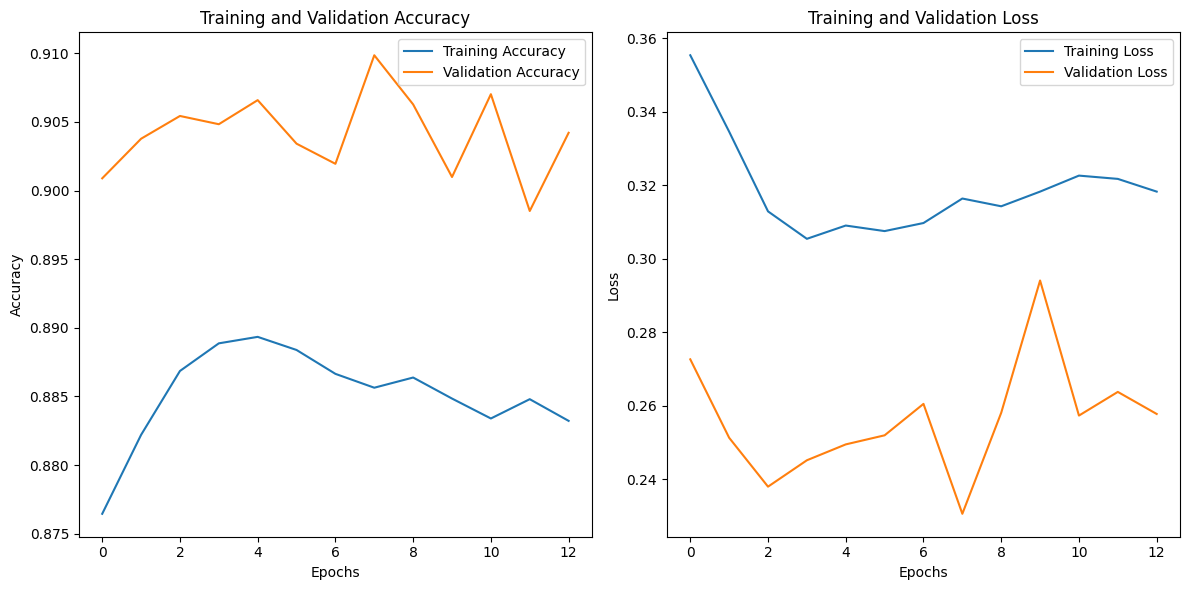

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     12099
           1       0.94      0.92      0.93     14078
           2       0.79      0.81      0.80      3449
           3       0.90      0.94      0.92      5723
           4       0.96      0.80      0.87      4766
           5       0.75      0.85      0.80      1496

    accuracy                           0.91     41611
   macro avg       0.88      0.88      0.88     41611
weighted avg       0.91      0.91      0.91     41611


Metrics:

Train Loss: 0.3182882070541382
Val Loss: 0.25777560472488403
Test Loss: 0.2305915355682373
AUC: 0.9931728653607969
Accuracy: 0.9092066884040833
Precision: 0.9112760276504581
Recall: 0.9092067001514023
F1-Score: 0.909071396822785

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


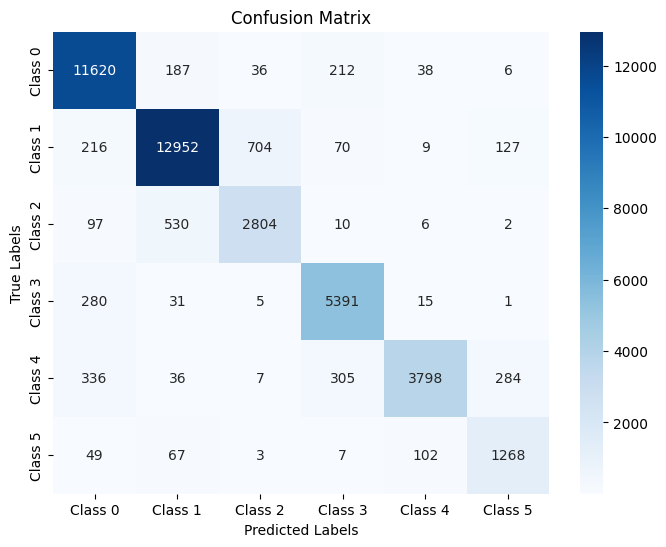


Model saved as 'word2vec_bigru_model_7.h5'



In [ ]:
word2vec_bigru_model_7, word2vec_bigru_metrics_7, word2vec_bigru_history_7 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="bigru"
)

word2vec_bigru_model_7.save('word2vec_bigru_model_7.h5')
print("\nModel saved as 'word2vec_bigru_model_7.h5'\n")

### 8. Batch 32 & LR 0.001

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - accuracy: 0.8385 - loss: 0.4222 - val_accuracy: 0.9208 - val_loss: 0.1691
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 77s 7ms/step - accuracy: 0.9196 - loss: 0.1709 - val_accuracy: 0.9230 - val_loss: 0.1602
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 77s 7ms/step - accuracy: 0.9232 - loss: 0.1547 - val_accuracy: 0.9251 - val_loss: 0.1502
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 77s 7ms/step - accuracy: 0.9235 - loss: 0.1494 - val_accuracy: 0.9227 - val_loss: 0.1539
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 77s 7ms/step - accuracy: 0.9254 - loss: 0.1437 - val_accuracy: 0.9242 - val_loss: 0.1539
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 77s 7ms/step - accuracy: 0.9277 - loss: 0.1372 - val_accuracy: 0.9241 - val_loss: 0.1500
Epoch 7/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 77s 7ms/step - accuracy: 0.9271 - loss: 0.1367 - val_accuracy: 0.9270 - val_loss: 0.1459
Epoch 8/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 77s 7ms/step - ac

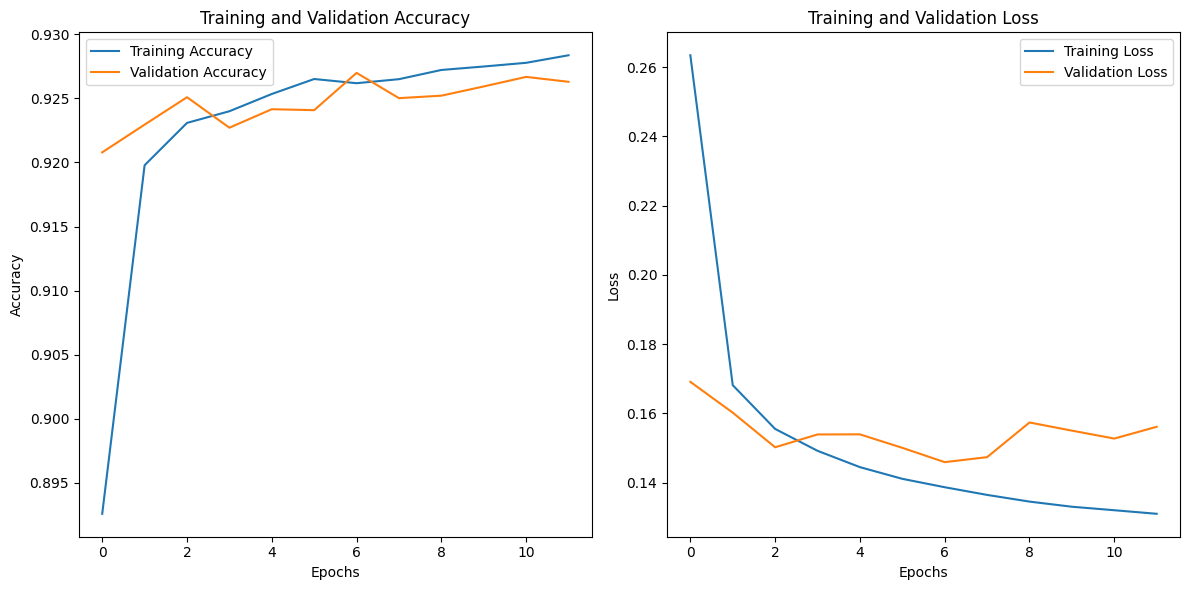

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.95      0.96     12099
           1       0.93      0.95      0.94     14078
           2       0.86      0.76      0.81      3449
           3       0.91      0.95      0.93      5723
           4       0.86      0.94      0.90      4766
           5       0.96      0.62      0.75      1496

    accuracy                           0.92     41611
   macro avg       0.91      0.86      0.88     41611
weighted avg       0.92      0.92      0.92     41611


Metrics:

Train Loss: 0.13098661601543427
Val Loss: 0.1561170518398285
Test Loss: 0.14771154522895813
AUC: 0.9962973335007296
Accuracy: 0.9227127432823181
Precision: 0.9234089371051808
Recall: 0.9227127442262864
F1-Score: 0.9212424628088953

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


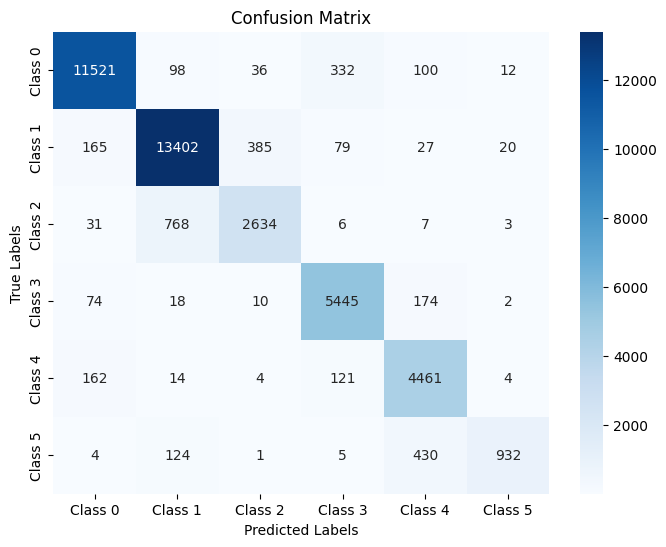


Model saved as 'word2vec_bigru_model_8.h5'



In [ ]:
word2vec_bigru_model_8, word2vec_bigru_metrics_8, word2vec_bigru_history_8 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="bigru"
)

word2vec_bigru_model_8.save('word2vec_bigru_model_8.h5')
print("\nModel saved as 'word2vec_bigru_model_8.h5'\n")

### 9. Batch 32 & LR 0.0001

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - accuracy: 0.6528 - loss: 0.9149 - val_accuracy: 0.8868 - val_loss: 0.2864
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 77s 7ms/step - accuracy: 0.8944 - loss: 0.2769 - val_accuracy: 0.9103 - val_loss: 0.2115
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 77s 7ms/step - accuracy: 0.9108 - loss: 0.2162 - val_accuracy: 0.9140 - val_loss: 0.1880
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 77s 7ms/step - accuracy: 0.9142 - loss: 0.1947 - val_accuracy: 0.9181 - val_loss: 0.1733
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 77s 7ms/step - accuracy: 0.9182 - loss: 0.1790 - val_accuracy: 0.9185 - val_loss: 0.1657
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 77s 7ms/step - accuracy: 0.9202 - loss: 0.1695 - val_accuracy: 0.9199 - val_loss: 0.1637
Epoch 7/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 77s 7ms/step - accuracy: 0.9216 - loss: 0.1625 - val_accuracy: 0.9201 - val_loss: 0.1598
Epoch 8/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 77s 7ms/step - ac

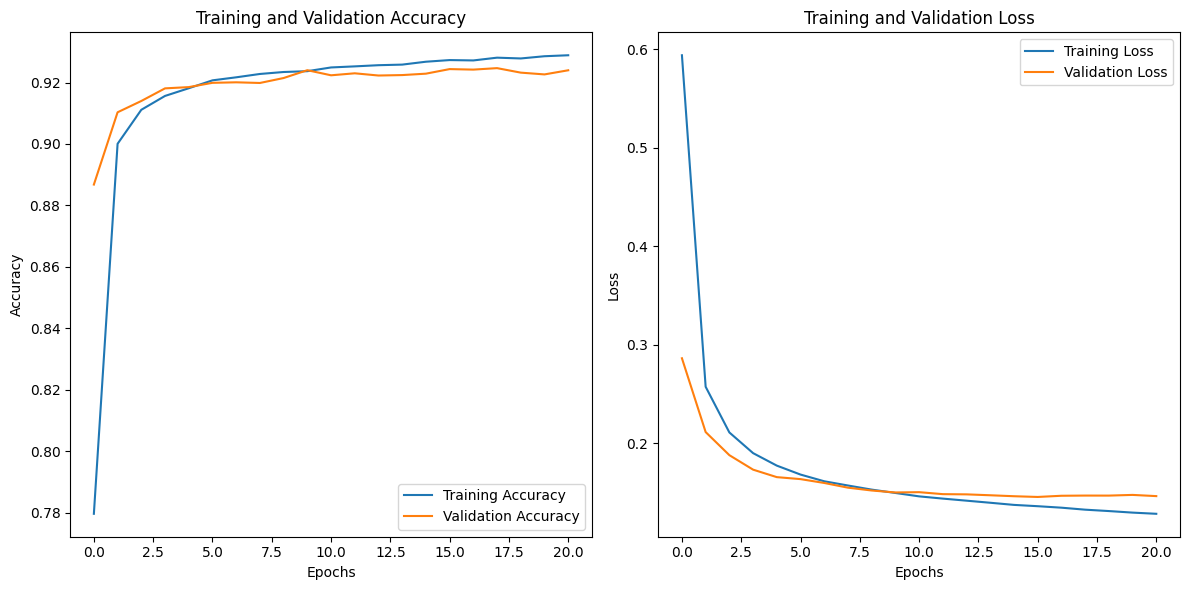

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     12099
           1       0.92      0.96      0.94     14078
           2       0.90      0.72      0.80      3449
           3       0.93      0.93      0.93      5723
           4       0.93      0.84      0.88      4766
           5       0.75      0.87      0.81      1496

    accuracy                           0.92     41611
   macro avg       0.90      0.88      0.89     41611
weighted avg       0.92      0.92      0.92     41611


Metrics:

Train Loss: 0.12845146656036377
Val Loss: 0.14640799164772034
Test Loss: 0.14793843030929565
AUC: 0.996287710510943
Accuracy: 0.9231452941894531
Precision: 0.9237139719011346
Recall: 0.9231453221503929
F1-Score: 0.9219617059898464

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


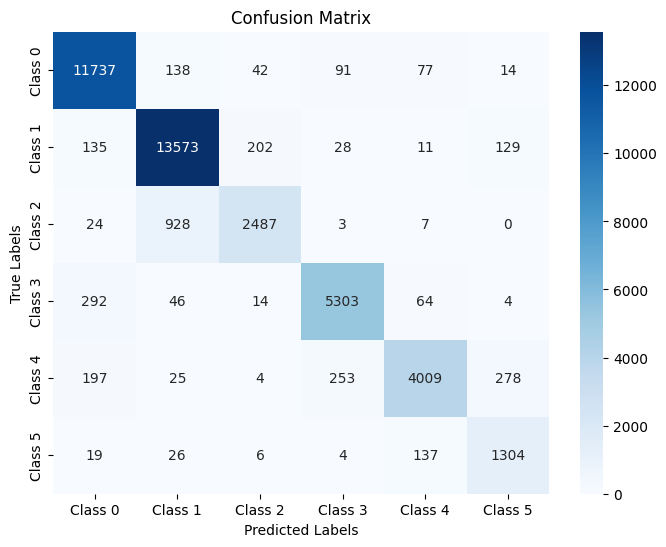


Model saved as 'word2vec_bigru_model_9.h5'



In [ ]:
word2vec_bigru_model_9, word2vec_bigru_metrics_9, word2vec_bigru_history_9 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="bigru"
)

word2vec_bigru_model_9.save('word2vec_bigru_model_9.h5')
print("\nModel saved as 'word2vec_bigru_model_9.h5'\n")

## LSTM

### 1. Batch 8 & LR 0.01

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 200s 5ms/step - accuracy: 0.3352 - loss: 1.5792 - val_accuracy: 0.3383 - val_loss: 1.5740
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 195s 5ms/step - accuracy: 0.3351 - loss: 1.5744 - val_accuracy: 0.3383 - val_loss: 1.5737
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 196s 5ms/step - accuracy: 0.3374 - loss: 1.5740 - val_accuracy: 0.3383 - val_loss: 1.5737
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 196s 5ms/step - accuracy: 0.3366 - loss: 1.5742 - val_accuracy: 0.3383 - val_loss: 1.5740
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 196s 5ms/step - accuracy: 0.3361 - loss: 1.5753 - val_accuracy: 0.3383 - val_loss: 1.5750
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 196s 5ms/step - accuracy: 0.3377 - loss: 1.5744 - val_accuracy: 0.3383 - val_loss: 1.5742
Epoch 7/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 196s 5ms/step - accuracy: 0.3378 - loss: 1.5735 - val_accuracy: 0.3383 - val_loss: 1.5730
Epoch 8/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 197s 5ms/s

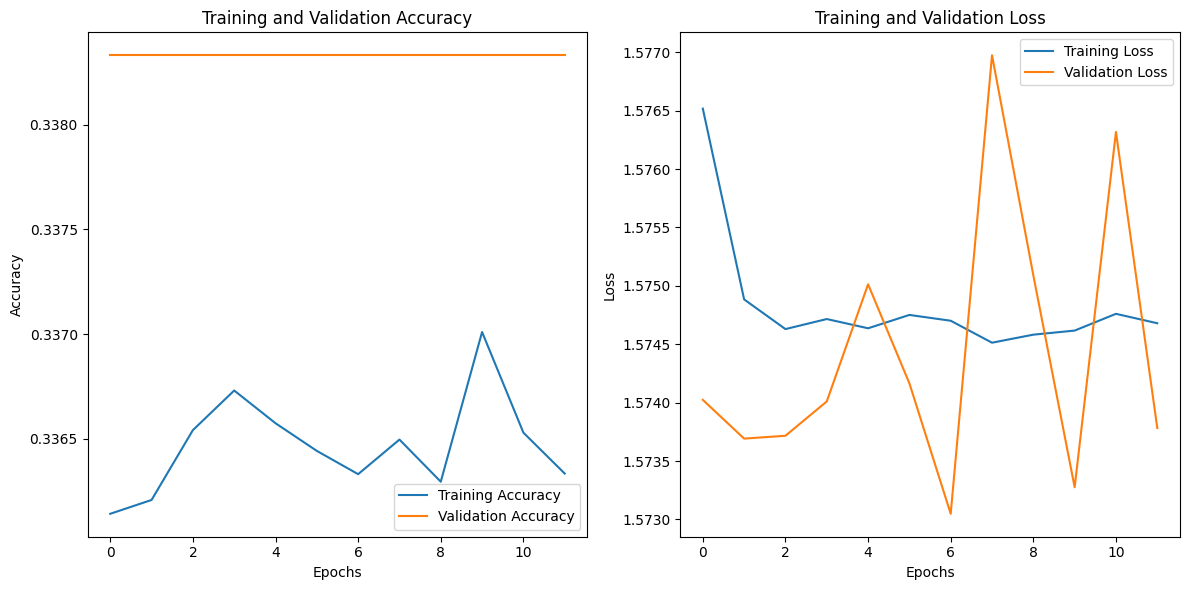

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12099
           1       0.34      1.00      0.51     14078
           2       0.00      0.00      0.00      3449
           3       0.00      0.00      0.00      5723
           4       0.00      0.00      0.00      4766
           5       0.00      0.00      0.00      1496

    accuracy                           0.34     41611
   macro avg       0.06      0.17      0.08     41611
weighted avg       0.11      0.34      0.17     41611


Metrics:

Train Loss: 1.5746797323226929
Val Loss: 1.5737826824188232
Test Loss: 1.5730302333831787
AUC: 0.5
Accuracy: 0.33832401037216187
Precision: 0.11446312956140597
Recall: 0.33832400086515585
F1-Score: 0.171054437471661

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


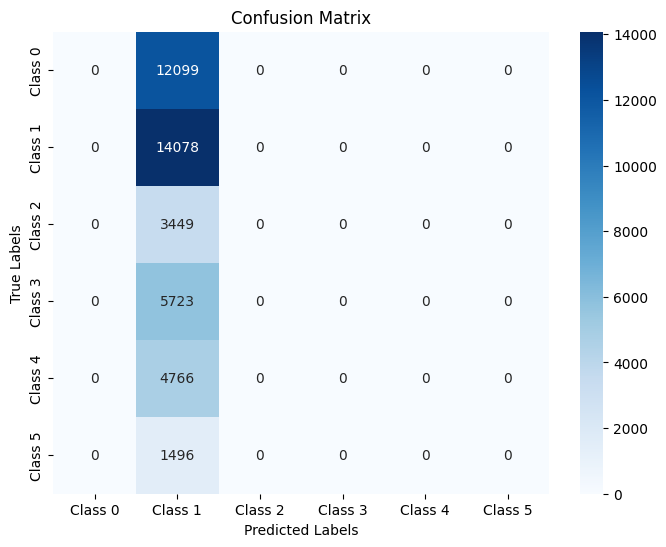


Model saved as 'word2vec_lstm_model_1.h5'



In [ ]:
word2vec_lstm_model_1, word2vec_lstm_metrics_1, word2vec_lstm_history_1 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="lstm"
)

word2vec_lstm_model_1.save('word2vec_lstm_model_1.h5')
print("\nModel saved as 'word2vec_lstm_model_1.h5'\n")

### 2. Batch 8 & LR 0.001

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 200s 5ms/step - accuracy: 0.3358 - loss: 1.5788 - val_accuracy: 0.3383 - val_loss: 1.5732
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 196s 5ms/step - accuracy: 0.3377 - loss: 1.5740 - val_accuracy: 0.3383 - val_loss: 1.5729
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 197s 5ms/step - accuracy: 0.3374 - loss: 1.5720 - val_accuracy: 0.3383 - val_loss: 1.5731
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 196s 5ms/step - accuracy: 0.3372 - loss: 1.5741 - val_accuracy: 0.3383 - val_loss: 1.5729
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 197s 5ms/step - accuracy: 0.3383 - loss: 1.5740 - val_accuracy: 0.3383 - val_loss: 1.5730
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 200s 5ms/step - accuracy: 0.3380 - loss: 1.5739 - val_accuracy: 0.3383 - val_loss: 1.5732
Epoch 7/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 196s 5ms/step - accuracy: 0.3383 - loss: 1.5734 - val_accuracy: 0.3383 - val_loss: 1.5730
Epoch 8/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 196s 5ms/s

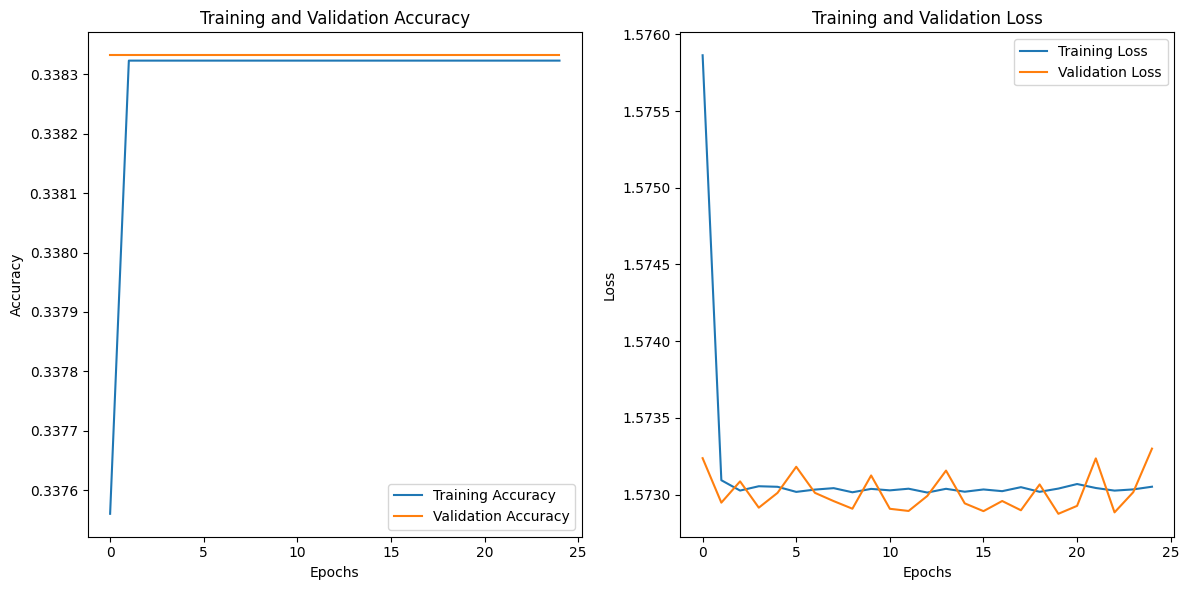

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12099
           1       0.34      1.00      0.51     14078
           2       0.00      0.00      0.00      3449
           3       0.00      0.00      0.00      5723
           4       0.00      0.00      0.00      4766
           5       0.00      0.00      0.00      1496

    accuracy                           0.34     41611
   macro avg       0.06      0.17      0.08     41611
weighted avg       0.11      0.34      0.17     41611


Metrics:

Train Loss: 1.57305109500885
Val Loss: 1.5732994079589844
Test Loss: 1.572856068611145
AUC: 0.5
Accuracy: 0.33832401037216187
Precision: 0.11446312956140597
Recall: 0.33832400086515585
F1-Score: 0.171054437471661

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


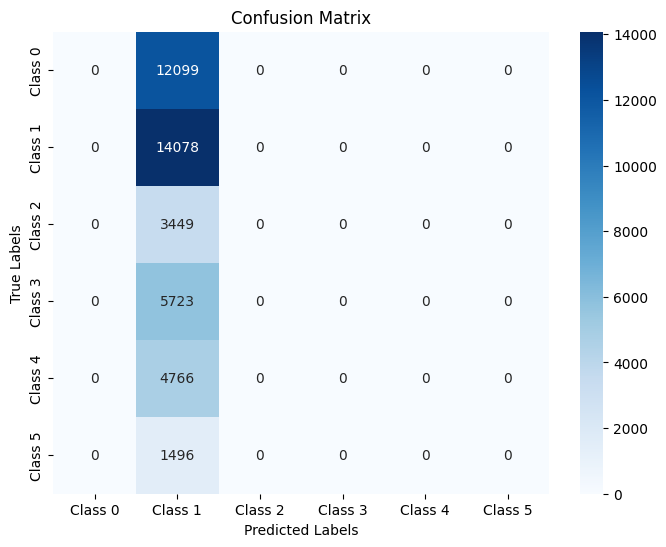


Model saved as 'word2vec_lstm_model_2.h5'



In [ ]:
word2vec_lstm_model_2, word2vec_lstm_metrics_2, word2vec_lstm_history_2 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="lstm"
)

word2vec_lstm_model_2.save('word2vec_lstm_model_2.h5')
print("\nModel saved as 'word2vec_lstm_model_2.h5'\n")

### 3. Batch 8 & LR 0.0001

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 198s 5ms/step - accuracy: 0.5924 - loss: 1.0720 - val_accuracy: 0.8156 - val_loss: 0.4898
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 194s 5ms/step - accuracy: 0.8343 - loss: 0.4538 - val_accuracy: 0.8831 - val_loss: 0.3000
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 195s 5ms/step - accuracy: 0.8872 - loss: 0.2945 - val_accuracy: 0.9030 - val_loss: 0.2335
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 195s 5ms/step - accuracy: 0.9027 - loss: 0.2338 - val_accuracy: 0.9108 - val_loss: 0.2066
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 195s 5ms/step - accuracy: 0.9112 - loss: 0.2031 - val_accuracy: 0.9157 - val_loss: 0.1809
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 195s 5ms/step - accuracy: 0.9160 - loss: 0.1845 - val_accuracy: 0.9193 - val_loss: 0.1726
Epoch 7/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 194s 5ms/step - accuracy: 0.9193 - loss: 0.1729 - val_accuracy: 0.9208 - val_loss: 0.1654
Epoch 8/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 194s 5ms/s

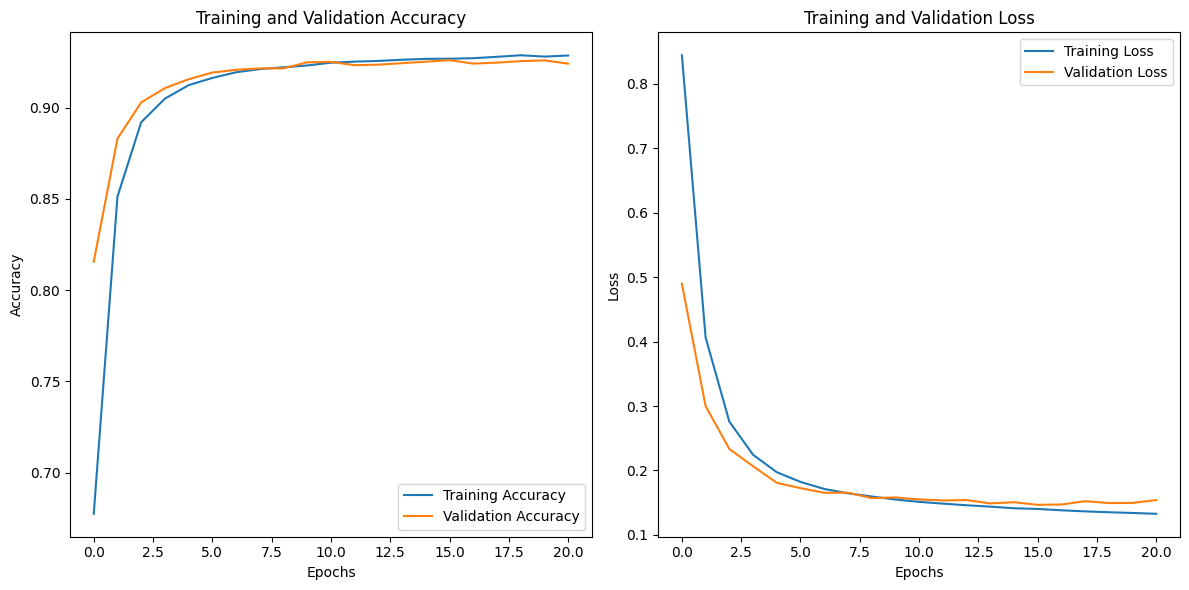

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     12099
           1       0.91      0.98      0.94     14078
           2       0.95      0.68      0.80      3449
           3       0.93      0.94      0.93      5723
           4       0.97      0.81      0.88      4766
           5       0.73      0.93      0.82      1496

    accuracy                           0.92     41611
   macro avg       0.91      0.89      0.89     41611
weighted avg       0.93      0.92      0.92     41611


Metrics:

Train Loss: 0.13277895748615265
Val Loss: 0.15413548052310944
Test Loss: 0.1479417383670807
AUC: 0.9961402537658475
Accuracy: 0.9247074127197266
Precision: 0.9282794855851222
Recall: 0.9247074090985556
F1-Score: 0.9229687122915847

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


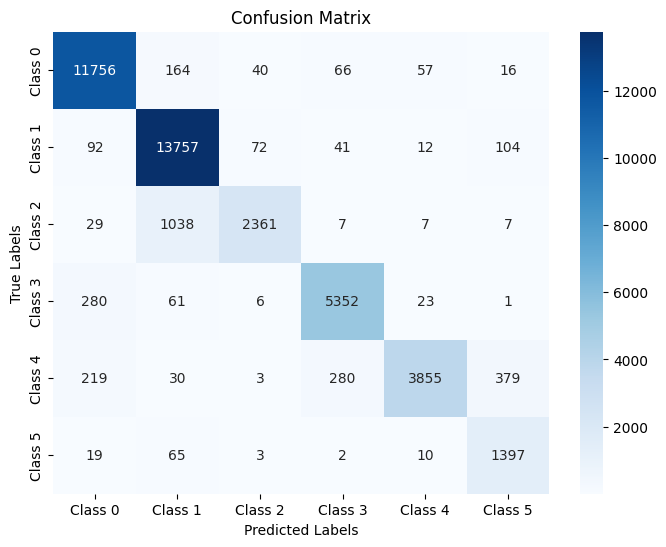


Model saved as 'word2vec_lstm_model_3.h5'



In [ ]:
word2vec_lstm_model_3, word2vec_lstm_metrics_3, word2vec_lstm_history_3 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="lstm"
)

word2vec_lstm_model_3.save('word2vec_lstm_model_3.h5')
print("\nModel saved as 'word2vec_lstm_model_3.h5'\n")

### 4. Batch 16 & LR 0.01

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 101s 5ms/step - accuracy: 0.3354 - loss: 1.5759 - val_accuracy: 0.3383 - val_loss: 1.5738
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.3369 - loss: 1.5732 - val_accuracy: 0.3383 - val_loss: 1.5738
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.3379 - loss: 1.5740 - val_accuracy: 0.3383 - val_loss: 1.5735
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.3378 - loss: 1.5736 - val_accuracy: 0.3383 - val_loss: 1.5738
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.3375 - loss: 1.5740 - val_accuracy: 0.3383 - val_loss: 1.5749
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.3384 - loss: 1.5744 - val_accuracy: 0.3383 - val_loss: 1.5738
Epoch 7/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.3367 - loss: 1.5734 - val_accuracy: 0.3383 - val_loss: 1.5745
Epoch 8/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - a

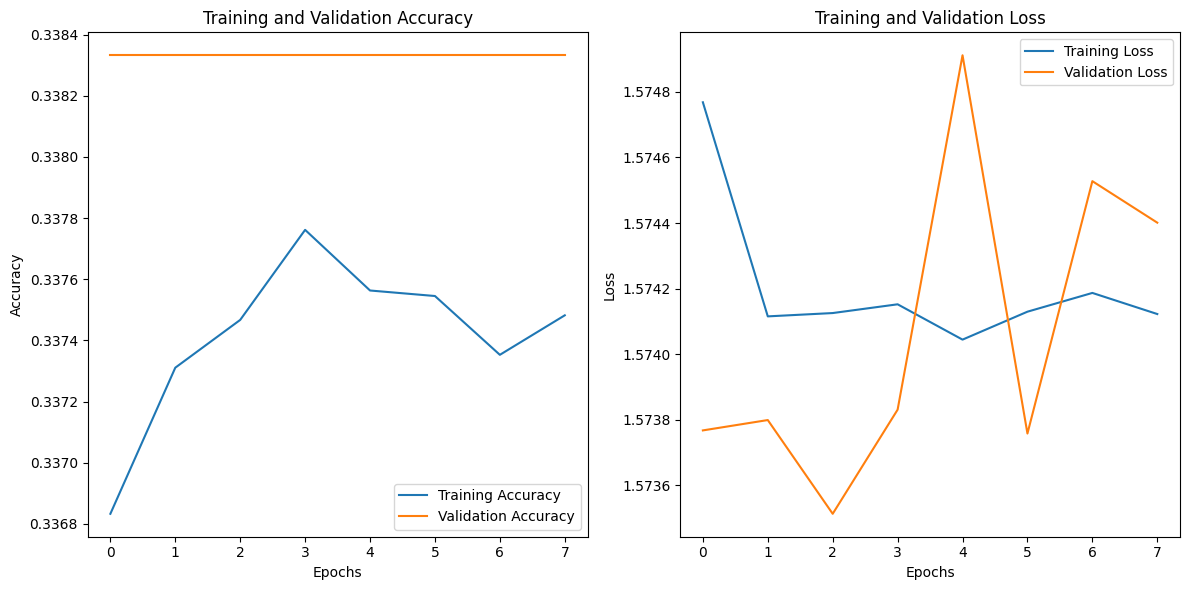

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12099
           1       0.34      1.00      0.51     14078
           2       0.00      0.00      0.00      3449
           3       0.00      0.00      0.00      5723
           4       0.00      0.00      0.00      4766
           5       0.00      0.00      0.00      1496

    accuracy                           0.34     41611
   macro avg       0.06      0.17      0.08     41611
weighted avg       0.11      0.34      0.17     41611


Metrics:

Train Loss: 1.574122428894043
Val Loss: 1.5744011402130127
Test Loss: 1.5734914541244507
AUC: 0.5
Accuracy: 0.33832401037216187
Precision: 0.11446312956140597
Recall: 0.33832400086515585
F1-Score: 0.171054437471661

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


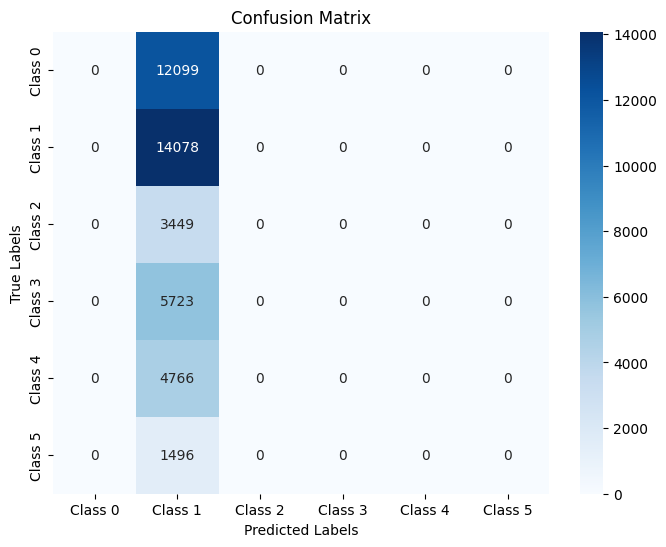


Model saved as 'word2vec_lstm_model_4.h5'



In [ ]:
word2vec_lstm_model_4, word2vec_lstm_metrics_4, word2vec_lstm_history_4 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="lstm"
)

word2vec_lstm_model_4.save('word2vec_lstm_model_4.h5')
print("\nModel saved as 'word2vec_lstm_model_4.h5'\n")

### 5. Batch 16 & LR 0.001

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 101s 5ms/step - accuracy: 0.7526 - loss: 0.6477 - val_accuracy: 0.9173 - val_loss: 0.1788
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.9180 - loss: 0.1838 - val_accuracy: 0.9234 - val_loss: 0.1620
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.9231 - loss: 0.1628 - val_accuracy: 0.9262 - val_loss: 0.1501
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.9252 - loss: 0.1524 - val_accuracy: 0.9266 - val_loss: 0.1475
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.9259 - loss: 0.1462 - val_accuracy: 0.9267 - val_loss: 0.1442
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.9274 - loss: 0.1418 - val_accuracy: 0.9239 - val_loss: 0.1481
Epoch 7/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.9282 - loss: 0.1372 - val_accuracy: 0.9264 - val_loss: 0.1497
Epoch 8/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - a

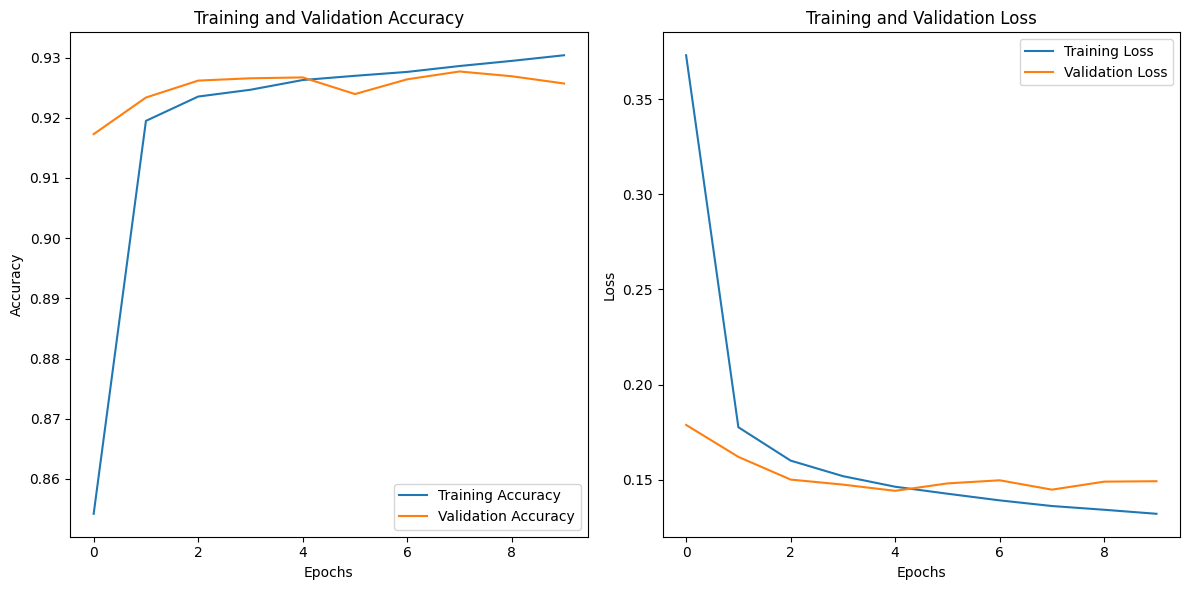

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     12099
           1       0.97      0.91      0.94     14078
           2       0.75      0.96      0.85      3449
           3       0.90      0.97      0.93      5723
           4       0.89      0.89      0.89      4766
           5       0.99      0.61      0.75      1496

    accuracy                           0.92     41611
   macro avg       0.91      0.88      0.89     41611
weighted avg       0.93      0.92      0.92     41611


Metrics:

Train Loss: 0.13214358687400818
Val Loss: 0.1492612361907959
Test Loss: 0.14504633843898773
AUC: 0.9962768704761727
Accuracy: 0.92391437292099
Precision: 0.9300703690818006
Recall: 0.9239143495710269
F1-Score: 0.9237396796088003

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


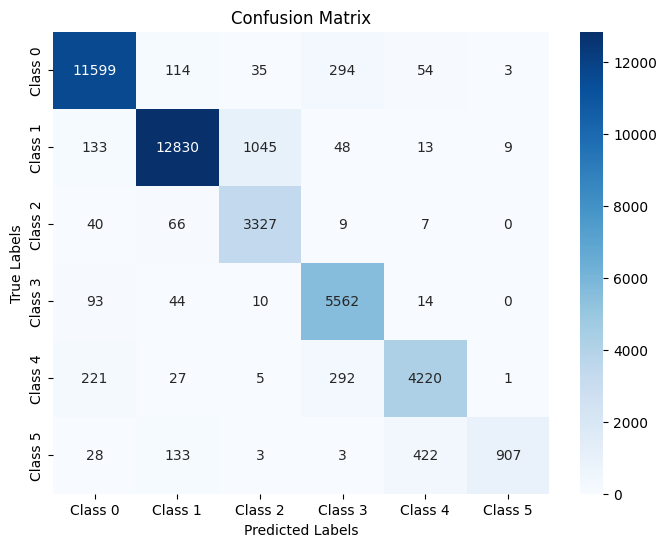


Model saved as 'word2vec_lstm_model_5.h5'



In [ ]:
word2vec_lstm_model_5, word2vec_lstm_metrics_5, word2vec_lstm_history_5 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="lstm"
)

word2vec_lstm_model_5.save('word2vec_lstm_model_5.h5')
print("\nModel saved as 'word2vec_lstm_model_5.h5'\n")

### 6. Batch 16 & LR 0.0001

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 101s 5ms/step - accuracy: 0.5378 - loss: 1.1779 - val_accuracy: 0.6868 - val_loss: 0.8191
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.7285 - loss: 0.7467 - val_accuracy: 0.8112 - val_loss: 0.5159
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.8319 - loss: 0.4561 - val_accuracy: 0.8755 - val_loss: 0.3209
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.8845 - loss: 0.3072 - val_accuracy: 0.8963 - val_loss: 0.2571
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.9001 - loss: 0.2513 - val_accuracy: 0.9034 - val_loss: 0.2231
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.9067 - loss: 0.2251 - val_accuracy: 0.9072 - val_loss: 0.2078
Epoch 7/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.9104 - loss: 0.2071 - val_accuracy: 0.9098 - val_loss: 0.1990
Epoch 8/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - a

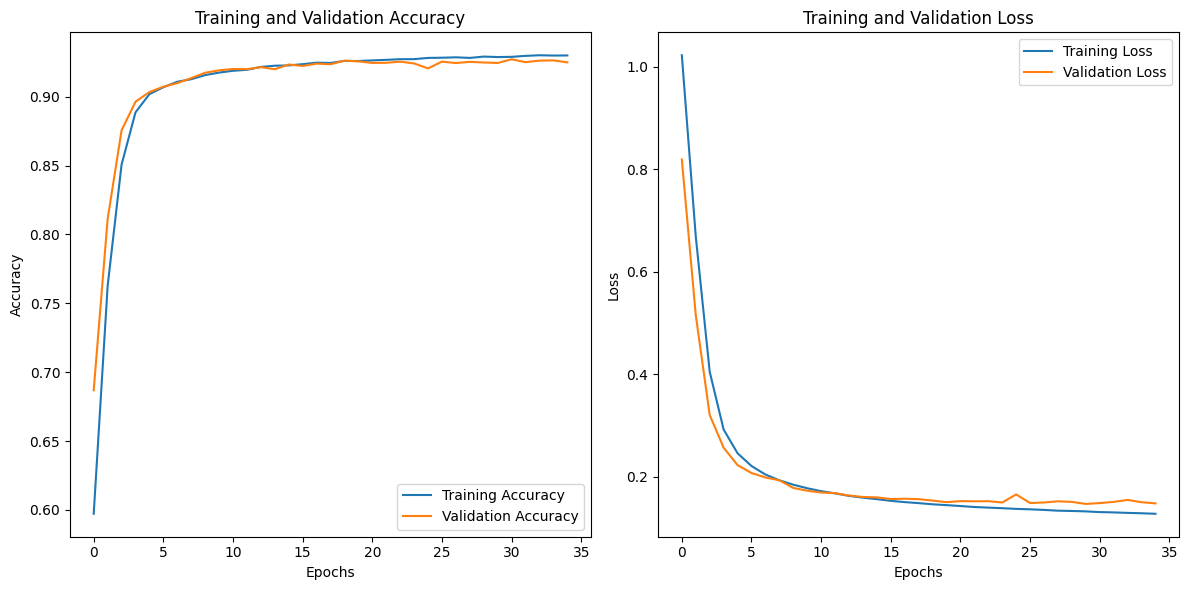

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     12099
           1       0.96      0.92      0.94     14078
           2       0.78      0.90      0.83      3449
           3       0.95      0.91      0.93      5723
           4       0.83      0.96      0.89      4766
           5       0.94      0.62      0.74      1496

    accuracy                           0.92     41611
   macro avg       0.90      0.88      0.88     41611
weighted avg       0.93      0.92      0.92     41611


Metrics:

Train Loss: 0.12820348143577576
Val Loss: 0.14846199750900269
Test Loss: 0.15110889077186584
AUC: 0.9960690234918457
Accuracy: 0.9224243760108948
Precision: 0.9264662324000409
Recall: 0.9224243589435486
F1-Score: 0.9222655749628886

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


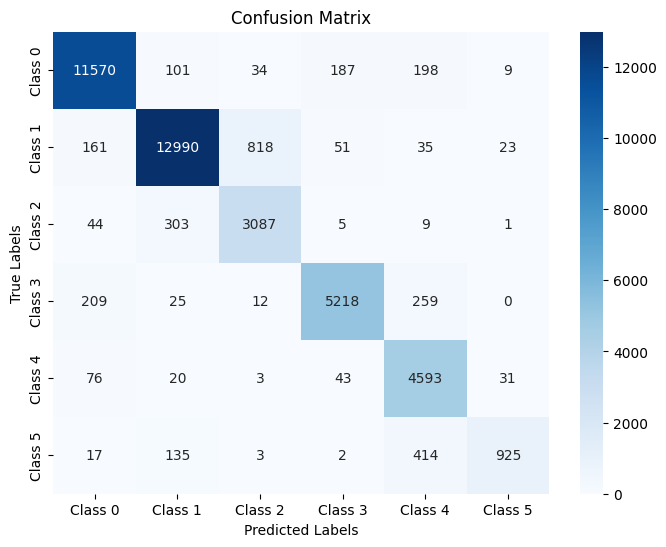


Model saved as 'word2vec_lstm_model_6.h5'



In [ ]:
word2vec_lstm_model_6, word2vec_lstm_metrics_6, word2vec_lstm_history_6 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="lstm"
)

word2vec_lstm_model_6.save('word2vec_lstm_model_6.h5')
print("\nModel saved as 'word2vec_lstm_model_6.h5'\n")

### 7. Batch 32 & LR 0.01

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 63s 6ms/step - accuracy: 0.3360 - loss: 1.5787 - val_accuracy: 0.3383 - val_loss: 1.5768
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.3375 - loss: 1.5740 - val_accuracy: 0.3383 - val_loss: 1.5742
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - accuracy: 0.3380 - loss: 1.5744 - val_accuracy: 0.3383 - val_loss: 1.5733
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.3372 - loss: 1.5735 - val_accuracy: 0.3383 - val_loss: 1.5738
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.3383 - loss: 1.5788 - val_accuracy: 0.3383 - val_loss: 1.5748
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.3392 - loss: 1.5743 - val_accuracy: 0.3383 - val_loss: 1.5753
Epoch 7/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.3388 - loss: 1.5746 - val_accuracy: 0.3383 - val_loss: 1.5732
Epoch 8/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - ac

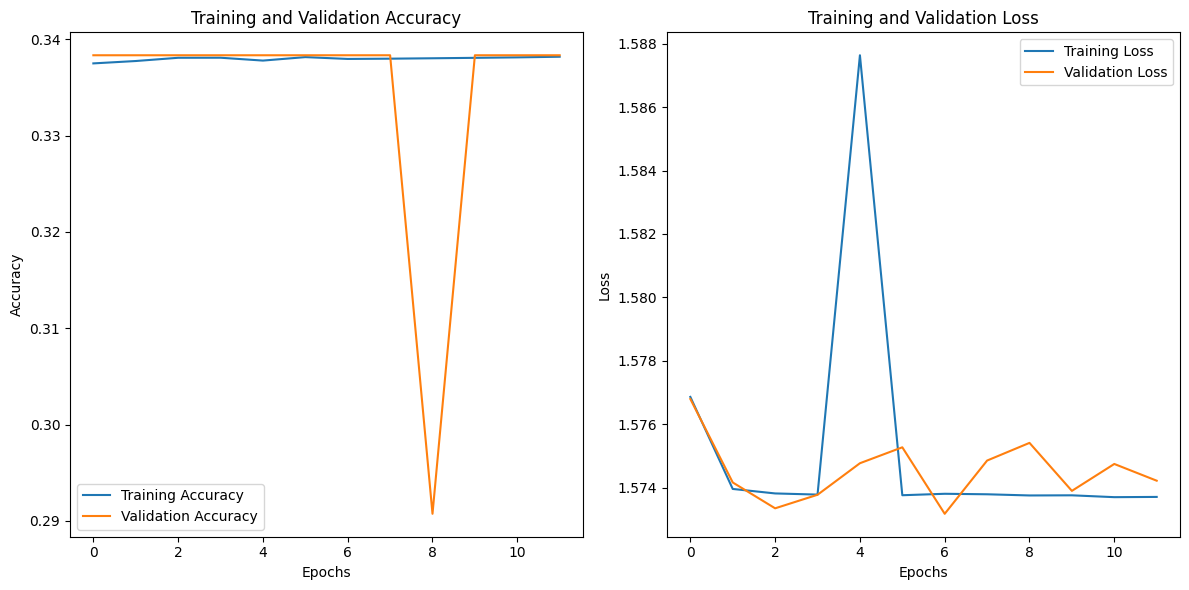

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12099
           1       0.34      1.00      0.51     14078
           2       0.00      0.00      0.00      3449
           3       0.00      0.00      0.00      5723
           4       0.00      0.00      0.00      4766
           5       0.00      0.00      0.00      1496

    accuracy                           0.34     41611
   macro avg       0.06      0.17      0.08     41611
weighted avg       0.11      0.34      0.17     41611


Metrics:

Train Loss: 1.5737080574035645
Val Loss: 1.5742197036743164
Test Loss: 1.5731539726257324
AUC: 0.5
Accuracy: 0.33832401037216187
Precision: 0.11446312956140597
Recall: 0.33832400086515585
F1-Score: 0.171054437471661

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


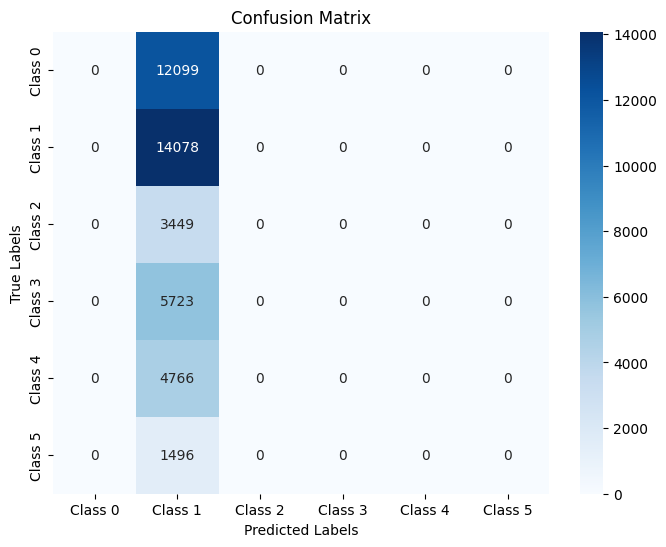


Model saved as 'word2vec_lstm_model_7.h5'



In [ ]:
word2vec_lstm_model_7, word2vec_lstm_metrics_7, word2vec_lstm_history_7 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="lstm"
)

word2vec_lstm_model_7.save('word2vec_lstm_model_7.h5')
print("\nModel saved as 'word2vec_lstm_model_7.h5'\n")

### 8. Batch 32 & LR 0.001

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 59s 6ms/step - accuracy: 0.6609 - loss: 0.8763 - val_accuracy: 0.9163 - val_loss: 0.1972
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - accuracy: 0.9151 - loss: 0.1942 - val_accuracy: 0.9212 - val_loss: 0.1626
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.9188 - loss: 0.1680 - val_accuracy: 0.9171 - val_loss: 0.1656
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - accuracy: 0.9199 - loss: 0.1616 - val_accuracy: 0.9237 - val_loss: 0.1567
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.9228 - loss: 0.1530 - val_accuracy: 0.9203 - val_loss: 0.1544
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.9217 - loss: 0.1495 - val_accuracy: 0.9216 - val_loss: 0.1537
Epoch 7/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - accuracy: 0.9249 - loss: 0.1439 - val_accuracy: 0.9255 - val_loss: 0.1478
Epoch 8/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - ac

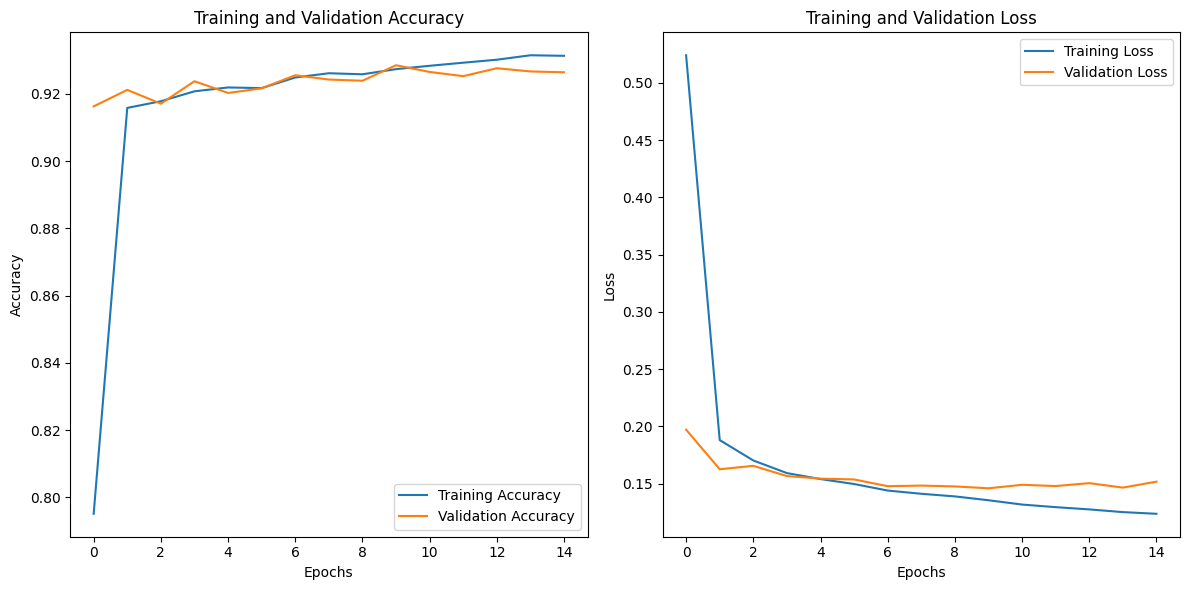

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     12099
           1       0.91      0.98      0.94     14078
           2       0.95      0.68      0.79      3449
           3       0.90      0.97      0.93      5723
           4       0.87      0.92      0.89      4766
           5       0.99      0.61      0.76      1496

    accuracy                           0.92     41611
   macro avg       0.93      0.85      0.88     41611
weighted avg       0.93      0.92      0.92     41611


Metrics:

Train Loss: 0.12368673086166382
Val Loss: 0.15176619589328766
Test Loss: 0.1499605029821396
AUC: 0.9962299293885938
Accuracy: 0.9241065979003906
Precision: 0.9268939300885538
Recall: 0.9241066064261854
F1-Score: 0.9213454354465234

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


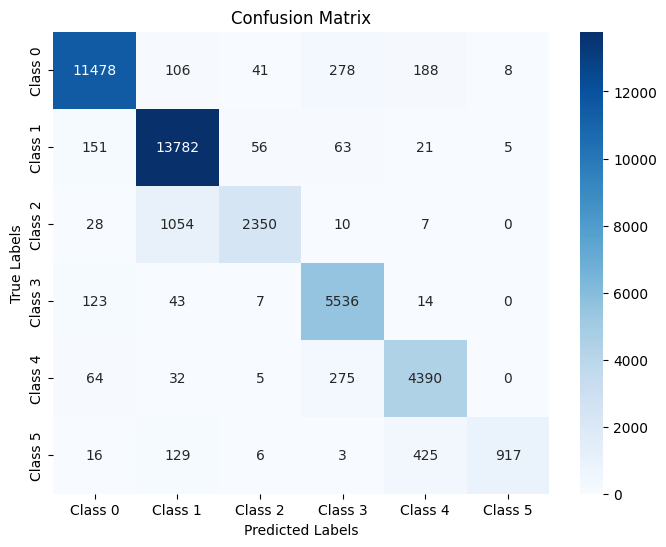


Model saved as 'word2vec_lstm_model_8.h5'



In [ ]:
word2vec_lstm_model_8, word2vec_lstm_metrics_8, word2vec_lstm_history_8 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="lstm"
)

word2vec_lstm_model_8.save('word2vec_lstm_model_8.h5')
print("\nModel saved as 'word2vec_lstm_model_8.h5'\n")

### 9. Batch 32 & LR 0.0001

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 59s 6ms/step - accuracy: 0.5363 - loss: 1.1936 - val_accuracy: 0.7191 - val_loss: 0.7666
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.7475 - loss: 0.6962 - val_accuracy: 0.8180 - val_loss: 0.4874
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - accuracy: 0.8320 - loss: 0.4597 - val_accuracy: 0.8549 - val_loss: 0.3850
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - accuracy: 0.8634 - loss: 0.3681 - val_accuracy: 0.8773 - val_loss: 0.3138
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - accuracy: 0.8779 - loss: 0.3173 - val_accuracy: 0.8829 - val_loss: 0.2938
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - accuracy: 0.8884 - loss: 0.2809 - val_accuracy: 0.8915 - val_loss: 0.2655
Epoch 7/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - accuracy: 0.8972 - loss: 0.2540 - val_accuracy: 0.9006 - val_loss: 0.2345
Epoch 8/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - ac

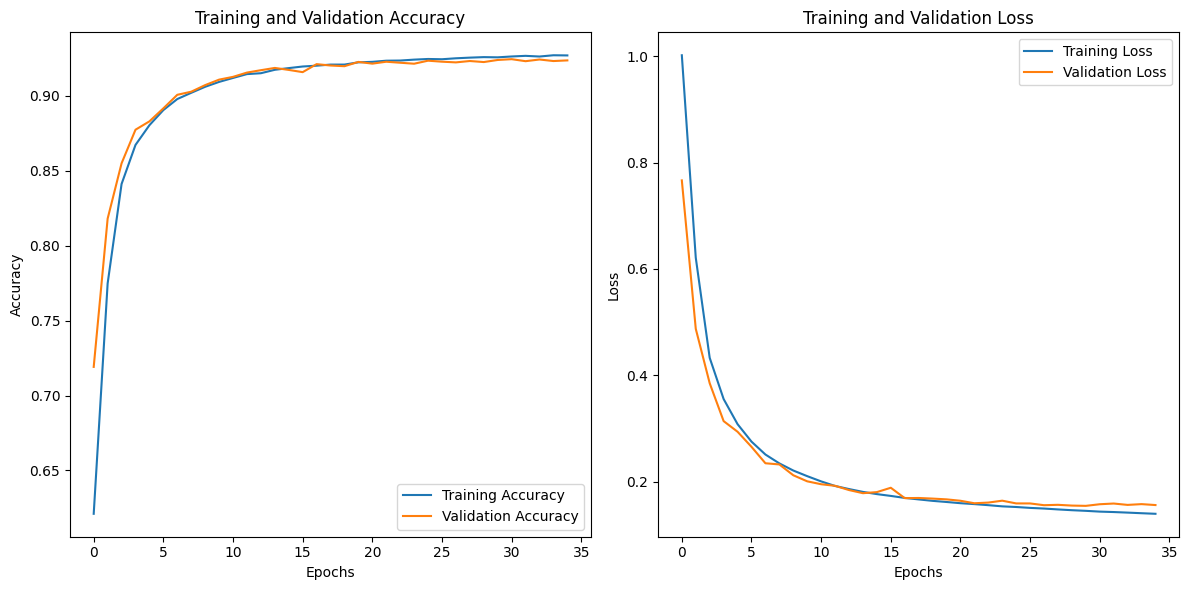

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     12099
           1       0.91      0.97      0.94     14078
           2       0.96      0.67      0.79      3449
           3       0.91      0.95      0.93      5723
           4       0.98      0.80      0.88      4766
           5       0.72      0.95      0.82      1496

    accuracy                           0.92     41611
   macro avg       0.91      0.89      0.89     41611
weighted avg       0.93      0.92      0.92     41611


Metrics:

Train Loss: 0.13948076963424683
Val Loss: 0.1559259444475174
Test Loss: 0.15689799189567566
AUC: 0.9957612129564216
Accuracy: 0.9221359491348267
Precision: 0.9270197847898469
Recall: 0.9221359736608108
F1-Score: 0.9203268573149804

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


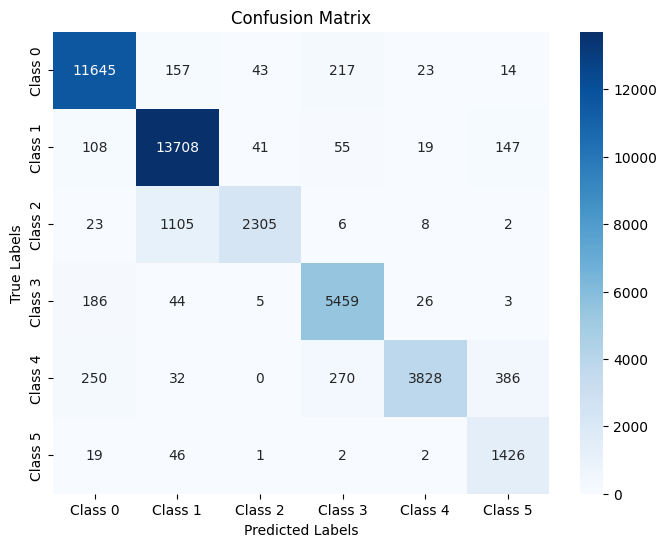


Model saved as 'word2vec_lstm_model_9.h5'



In [ ]:
word2vec_lstm_model_9, word2vec_lstm_metrics_9, word2vec_lstm_history_9 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="lstm"
)

word2vec_lstm_model_9.save('word2vec_lstm_model_9.h5')
print("\nModel saved as 'word2vec_lstm_model_9.h5'\n")

## Bi-LSTM

### 1. Batch 8 & LR 0.01

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 311s 7ms/step - accuracy: 0.8251 - loss: 0.5079 - val_accuracy: 0.8823 - val_loss: 0.3244
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 308s 7ms/step - accuracy: 0.8669 - loss: 0.3875 - val_accuracy: 0.8693 - val_loss: 0.4253
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 309s 7ms/step - accuracy: 0.8689 - loss: 0.3771 - val_accuracy: 0.8816 - val_loss: 0.3141
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 308s 7ms/step - accuracy: 0.8658 - loss: 0.3807 - val_accuracy: 0.8821 - val_loss: 0.3293
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 308s 7ms/step - accuracy: 0.8628 - loss: 0.3861 - val_accuracy: 0.8860 - val_loss: 0.3147
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 309s 7ms/step - accuracy: 0.8601 - loss: 0.4029 - val_accuracy: 0.8774 - val_loss: 0.3243
Epoch 7/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 308s 7ms/step - accuracy: 0.8586 - loss: 0.4079 - val_accuracy: 0.8879 - val_loss: 0.3152
Epoch 8/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 308s 7ms/s

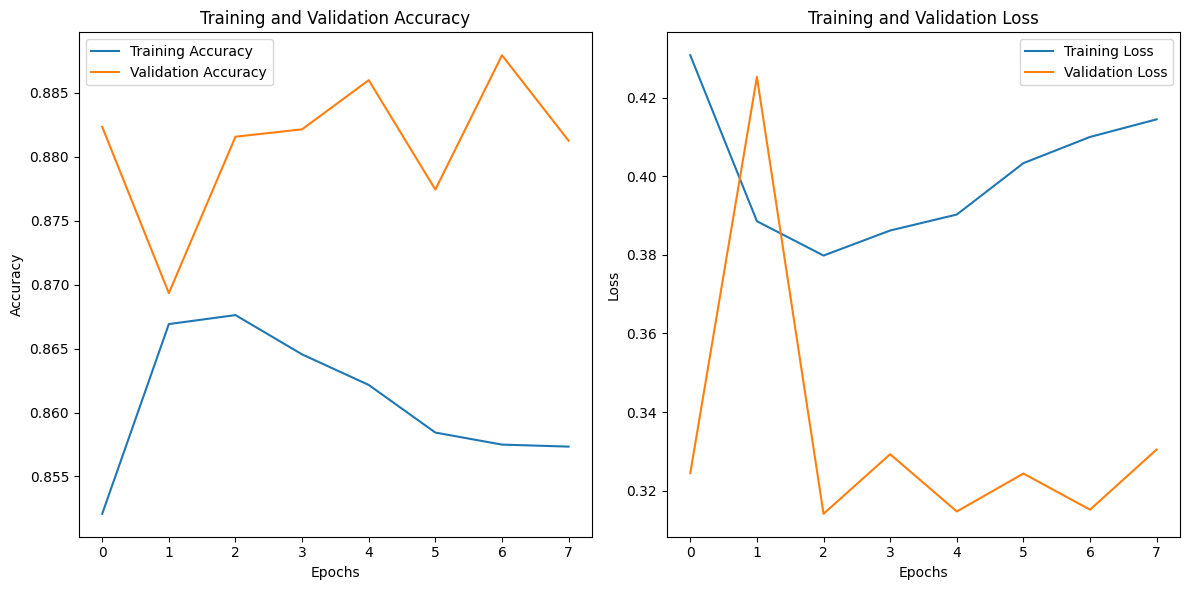

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.94      0.92     12099
           1       0.91      0.92      0.92     14078
           2       0.83      0.69      0.76      3449
           3       0.84      0.91      0.87      5723
           4       0.83      0.86      0.84      4766
           5       0.98      0.42      0.59      1496

    accuracy                           0.88     41611
   macro avg       0.88      0.79      0.82     41611
weighted avg       0.88      0.88      0.88     41611


Metrics:

Train Loss: 0.41452112793922424
Val Loss: 0.3304709792137146
Test Loss: 0.31561461091041565
AUC: 0.9877055690558723
Accuracy: 0.8804883360862732
Precision: 0.8820126072383735
Recall: 0.8804883324121026
F1-Score: 0.8764016925571684

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


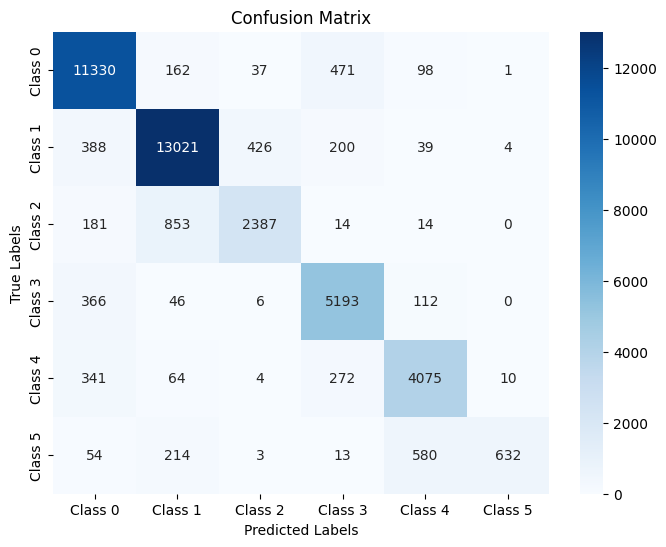


Model saved as 'word2vec_bilstm_model_1.h5'



In [ ]:
word2vec_bilstm_model_1, word2vec_bilstm_metrics_1, word2vec_bilstm_history_1 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="bilstm"
)

word2vec_bilstm_model_1.save('word2vec_bilstm_model_1.h5')
print("\nModel saved as 'word2vec_bilstm_model_1.h5'\n")

### 2. Batch 8 & LR 0.001

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 311s 7ms/step - accuracy: 0.8563 - loss: 0.3703 - val_accuracy: 0.9217 - val_loss: 0.1640
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 312s 7ms/step - accuracy: 0.9206 - loss: 0.1701 - val_accuracy: 0.9230 - val_loss: 0.1587
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 310s 7ms/step - accuracy: 0.9234 - loss: 0.1578 - val_accuracy: 0.9226 - val_loss: 0.1594
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 319s 8ms/step - accuracy: 0.9234 - loss: 0.1537 - val_accuracy: 0.9214 - val_loss: 0.1641
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 321s 8ms/step - accuracy: 0.9238 - loss: 0.1526 - val_accuracy: 0.9232 - val_loss: 0.1600
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 322s 8ms/step - accuracy: 0.9246 - loss: 0.1503 - val_accuracy: 0.9230 - val_loss: 0.1603
Epoch 7/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 324s 8ms/step - accuracy: 0.9237 - loss: 0.1501 - val_accuracy: 0.9225 - val_loss: 0.1669
Epoch 7: early stopping
Restoring model weights from th

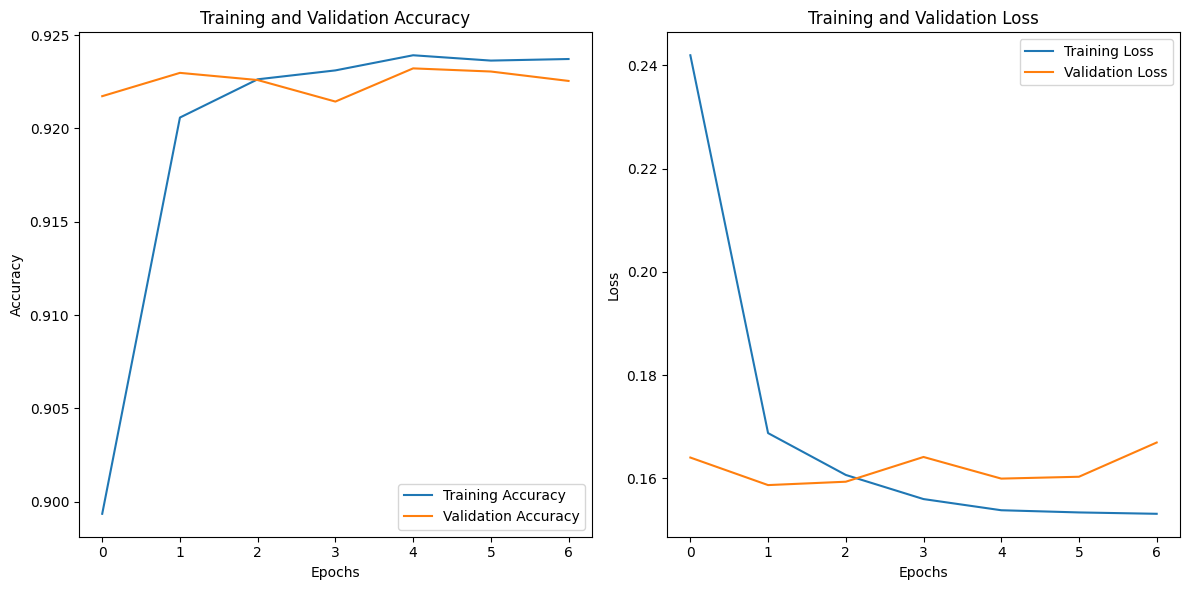

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.94      0.96     12099
           1       0.91      0.97      0.94     14078
           2       0.89      0.71      0.79      3449
           3       0.90      0.96      0.93      5723
           4       0.87      0.91      0.89      4766
           5       0.85      0.70      0.77      1496

    accuracy                           0.92     41611
   macro avg       0.90      0.86      0.88     41611
weighted avg       0.92      0.92      0.92     41611


Metrics:

Train Loss: 0.15313932299613953
Val Loss: 0.16694581508636475
Test Loss: 0.1590254306793213
AUC: 0.995825064158383
Accuracy: 0.9208382368087769
Precision: 0.9207897643250491
Recall: 0.920838239888491
F1-Score: 0.9192911325793295

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


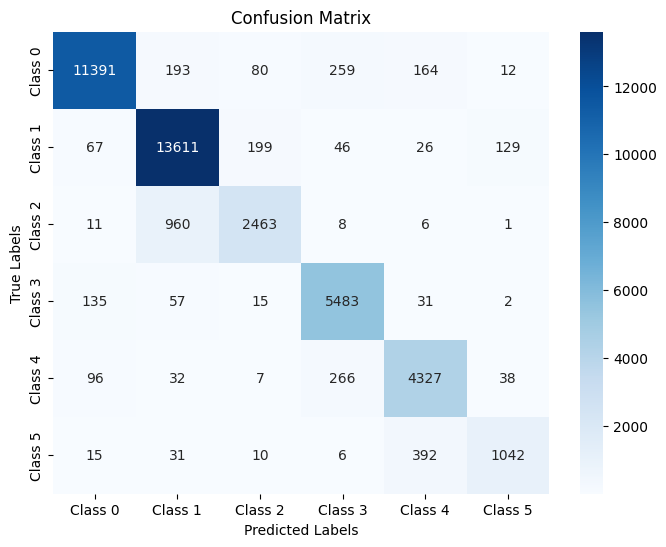


Model saved as 'word2vec_bilstm_model_2.h5'



In [ ]:
word2vec_bilstm_model_2, word2vec_bilstm_metrics_2, word2vec_bilstm_history_2 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="bilstm"
)

word2vec_bilstm_model_2.save('word2vec_bilstm_model_2.h5')
print("\nModel saved as 'word2vec_bilstm_model_2.h5'\n")

### 3. Batch 8 & LR 0.0001

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 329s 8ms/step - accuracy: 0.7272 - loss: 0.7402 - val_accuracy: 0.8860 - val_loss: 0.2859
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 324s 8ms/step - accuracy: 0.8983 - loss: 0.2571 - val_accuracy: 0.9113 - val_loss: 0.2031
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 310s 7ms/step - accuracy: 0.9104 - loss: 0.2044 - val_accuracy: 0.9158 - val_loss: 0.1801
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 309s 7ms/step - accuracy: 0.9168 - loss: 0.1809 - val_accuracy: 0.9183 - val_loss: 0.1693
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 311s 7ms/step - accuracy: 0.9204 - loss: 0.1677 - val_accuracy: 0.9199 - val_loss: 0.1640
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 311s 7ms/step - accuracy: 0.9228 - loss: 0.1578 - val_accuracy: 0.9205 - val_loss: 0.1599
Epoch 7/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 315s 8ms/step - accuracy: 0.9238 - loss: 0.1534 - val_accuracy: 0.9226 - val_loss: 0.1573
Epoch 8/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 312s 8ms/s

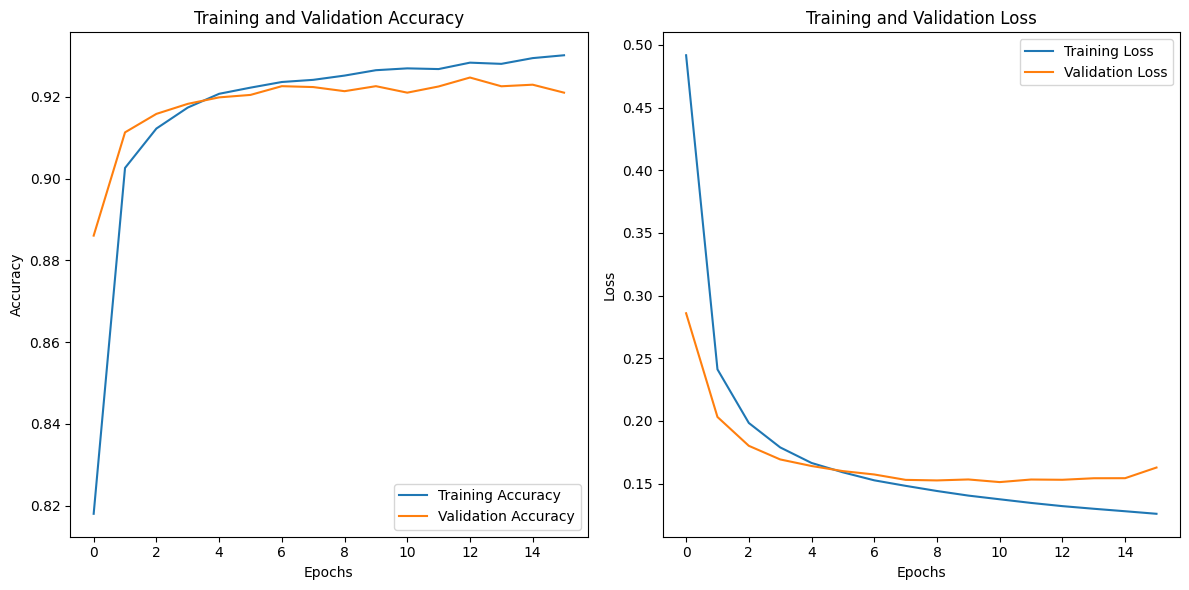

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.97      0.96     12099
           1       0.96      0.91      0.94     14078
           2       0.77      0.91      0.83      3449
           3       0.95      0.90      0.93      5723
           4       0.91      0.87      0.89      4766
           5       0.74      0.86      0.80      1496

    accuracy                           0.92     41611
   macro avg       0.88      0.90      0.89     41611
weighted avg       0.93      0.92      0.92     41611


Metrics:

Train Loss: 0.12588118016719818
Val Loss: 0.16279372572898865
Test Loss: 0.14953133463859558
AUC: 0.9961778473713782
Accuracy: 0.9211266040802002
Precision: 0.9251354709509306
Recall: 0.9211266251712288
F1-Score: 0.9220694376505719

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


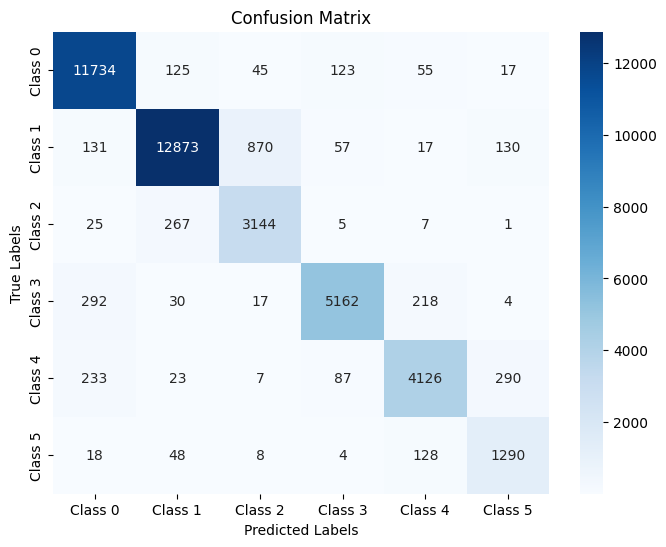


Model saved as 'word2vec_bilstm_model_3.h5'



In [ ]:
word2vec_bilstm_model_3, word2vec_bilstm_metrics_3, word2vec_bilstm_history_3 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="bilstm"
)

word2vec_bilstm_model_3.save('word2vec_bilstm_model_3.h5')
print("\nModel saved as 'word2vec_bilstm_model_3.h5'\n")

### 4. Batch 16 & LR 0.01

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 161s 8ms/step - accuracy: 0.8507 - loss: 0.4264 - val_accuracy: 0.8953 - val_loss: 0.2609
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 156s 7ms/step - accuracy: 0.8856 - loss: 0.3100 - val_accuracy: 0.8963 - val_loss: 0.2811
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 156s 8ms/step - accuracy: 0.8887 - loss: 0.3012 - val_accuracy: 0.9014 - val_loss: 0.2527
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 155s 7ms/step - accuracy: 0.8897 - loss: 0.2960 - val_accuracy: 0.9034 - val_loss: 0.2461
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 157s 8ms/step - accuracy: 0.8927 - loss: 0.2884 - val_accuracy: 0.9034 - val_loss: 0.2622
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 156s 7ms/step - accuracy: 0.8907 - loss: 0.2986 - val_accuracy: 0.9019 - val_loss: 0.2514
Epoch 7/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 157s 8ms/step - accuracy: 0.8897 - loss: 0.3024 - val_accuracy: 0.8981 - val_loss: 0.2619
Epoch 8/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 157s 8ms/s

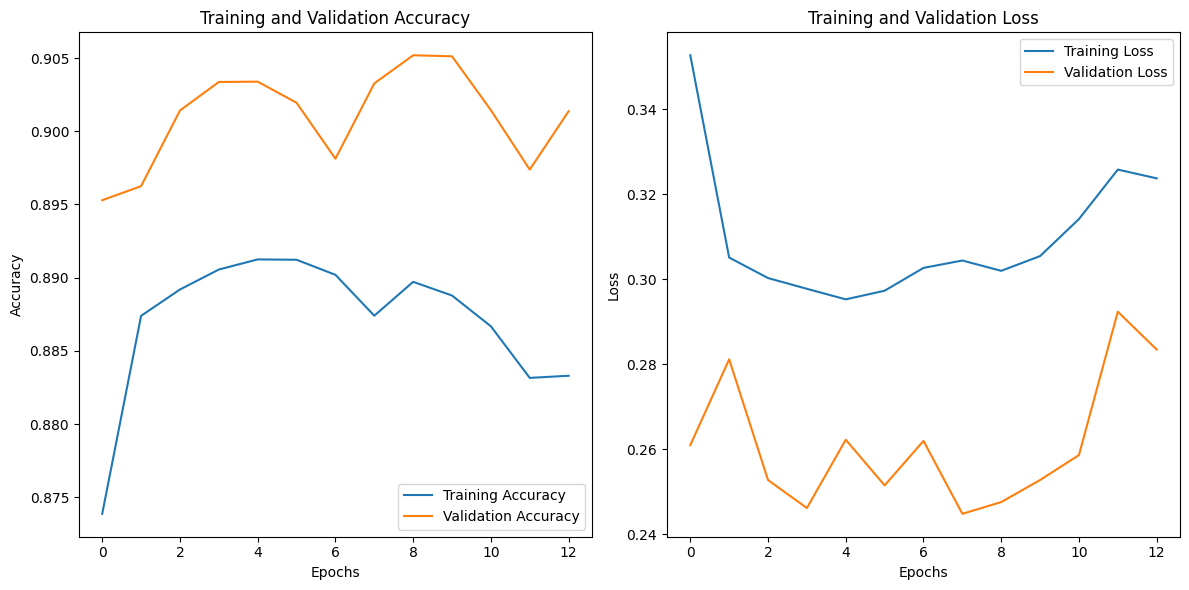

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.96      0.93     12099
           1       0.90      0.96      0.93     14078
           2       0.93      0.62      0.74      3449
           3       0.91      0.89      0.90      5723
           4       0.92      0.82      0.87      4766
           5       0.77      0.82      0.80      1496

    accuracy                           0.90     41611
   macro avg       0.89      0.85      0.86     41611
weighted avg       0.90      0.90      0.90     41611


Metrics:

Train Loss: 0.3237324655056
Val Loss: 0.2834385335445404
Test Loss: 0.25665754079818726
AUC: 0.9918975832595637
Accuracy: 0.9027180075645447
Precision: 0.9041914301878154
Recall: 0.9027180312898032
F1-Score: 0.8998114203247286

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


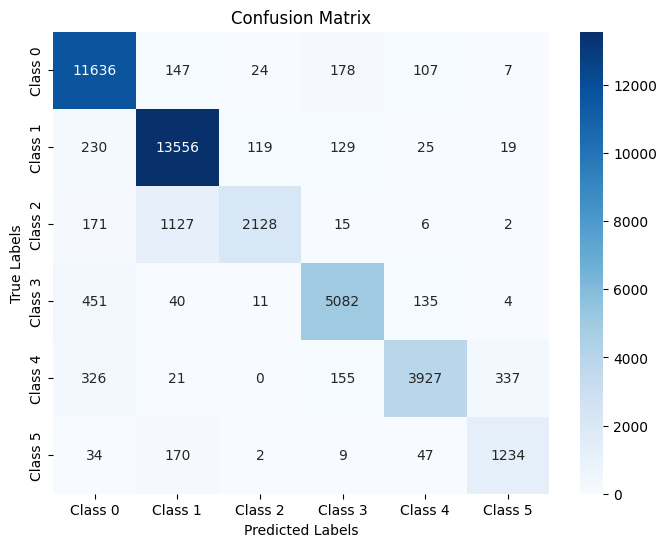


Model saved as 'word2vec_bilstm_model_4.h5'



In [ ]:
word2vec_bilstm_model_4, word2vec_bilstm_metrics_4, word2vec_bilstm_history_4 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="bilstm"
)

word2vec_bilstm_model_4.save('word2vec_bilstm_model_4.h5')
print("\nModel saved as 'word2vec_bilstm_model_4.h5'\n")

### 5. Batch 16 & LR 0.001

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 170s 8ms/step - accuracy: 0.8453 - loss: 0.4057 - val_accuracy: 0.9198 - val_loss: 0.1674
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 162s 8ms/step - accuracy: 0.9208 - loss: 0.1650 - val_accuracy: 0.9217 - val_loss: 0.1537
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 159s 8ms/step - accuracy: 0.9235 - loss: 0.1516 - val_accuracy: 0.9241 - val_loss: 0.1485
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 166s 8ms/step - accuracy: 0.9253 - loss: 0.1445 - val_accuracy: 0.9249 - val_loss: 0.1527
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 166s 8ms/step - accuracy: 0.9263 - loss: 0.1415 - val_accuracy: 0.9212 - val_loss: 0.1562
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 159s 8ms/step - accuracy: 0.9271 - loss: 0.1359 - val_accuracy: 0.9257 - val_loss: 0.1493
Epoch 7/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 159s 8ms/step - accuracy: 0.9280 - loss: 0.1338 - val_accuracy: 0.9243 - val_loss: 0.1572
Epoch 8/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 160s 8ms/s

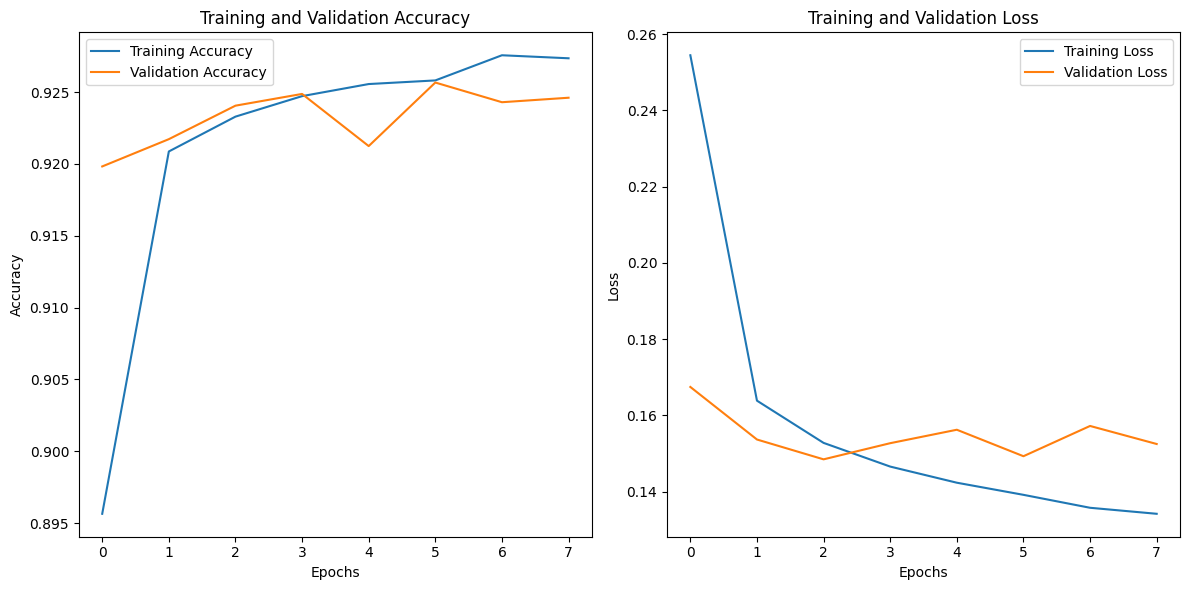

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.95      0.96     12099
           1       0.91      0.97      0.94     14078
           2       0.93      0.70      0.80      3449
           3       0.92      0.93      0.93      5723
           4       0.87      0.90      0.89      4766
           5       0.79      0.75      0.77      1496

    accuracy                           0.92     41611
   macro avg       0.90      0.87      0.88     41611
weighted avg       0.92      0.92      0.92     41611


Metrics:

Train Loss: 0.13416872918605804
Val Loss: 0.15248191356658936
Test Loss: 0.14849314093589783
AUC: 0.9962993654511519
Accuracy: 0.9215111136436462
Precision: 0.9219741349893299
Recall: 0.9215111388815458
F1-Score: 0.9200552051518194

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


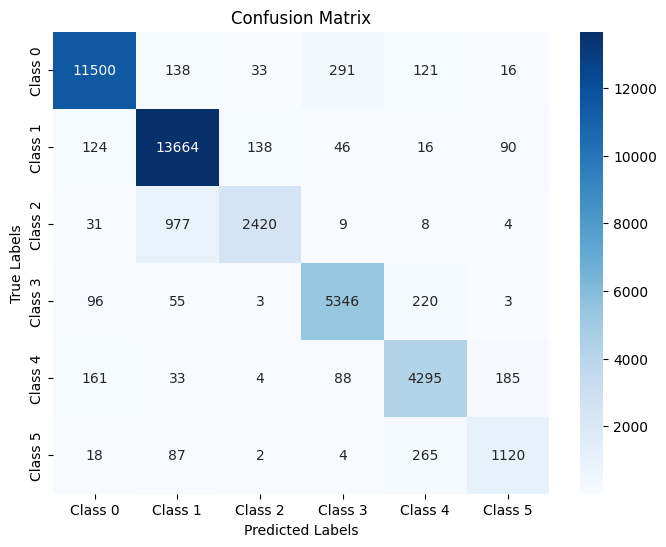


Model saved as 'word2vec_bilstm_model_5.h5'



In [ ]:
word2vec_bilstm_model_5, word2vec_bilstm_metrics_5, word2vec_bilstm_history_5 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="bilstm"
)

word2vec_bilstm_model_5.save('word2vec_bilstm_model_5.h5')
print("\nModel saved as 'word2vec_bilstm_model_5.h5'\n")

### 6. Batch 16 & LR 0.0001

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 162s 8ms/step - accuracy: 0.6915 - loss: 0.8417 - val_accuracy: 0.8792 - val_loss: 0.3062
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 156s 7ms/step - accuracy: 0.8850 - loss: 0.3022 - val_accuracy: 0.9018 - val_loss: 0.2277
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 156s 8ms/step - accuracy: 0.9046 - loss: 0.2305 - val_accuracy: 0.9090 - val_loss: 0.2067
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 155s 7ms/step - accuracy: 0.9122 - loss: 0.2013 - val_accuracy: 0.9152 - val_loss: 0.1829
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 156s 8ms/step - accuracy: 0.9162 - loss: 0.1836 - val_accuracy: 0.9153 - val_loss: 0.1785
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 155s 7ms/step - accuracy: 0.9180 - loss: 0.1744 - val_accuracy: 0.9174 - val_loss: 0.1697
Epoch 7/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 159s 8ms/step - accuracy: 0.9209 - loss: 0.1644 - val_accuracy: 0.9193 - val_loss: 0.1658
Epoch 8/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 156s 8ms/s

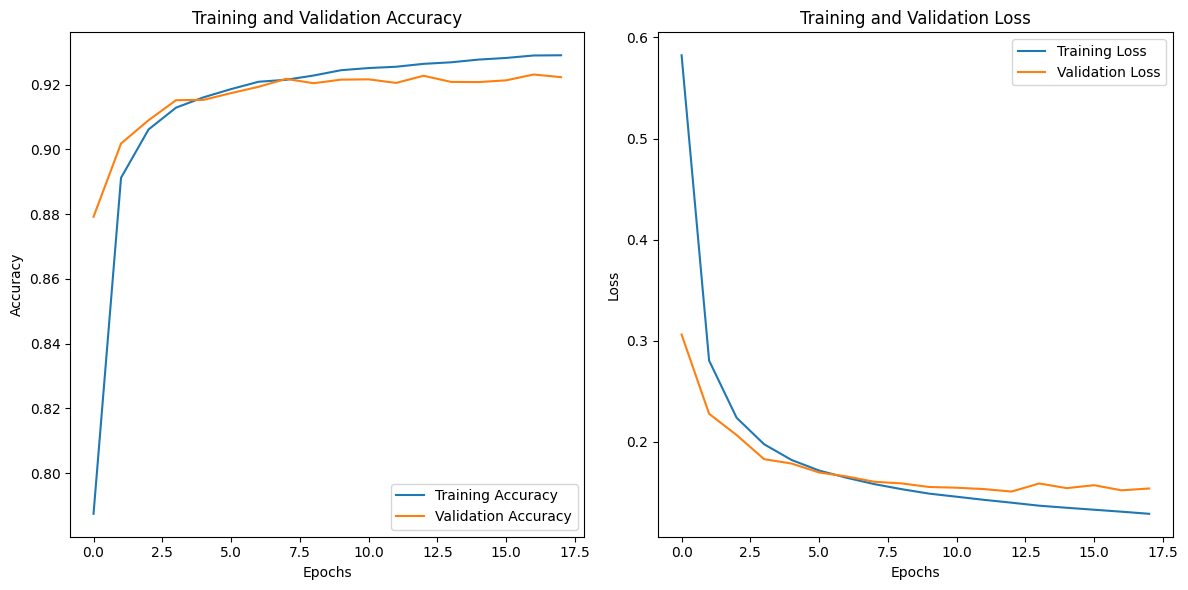

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     12099
           1       0.92      0.97      0.94     14078
           2       0.91      0.70      0.79      3449
           3       0.93      0.92      0.92      5723
           4       0.92      0.84      0.88      4766
           5       0.75      0.88      0.81      1496

    accuracy                           0.92     41611
   macro avg       0.89      0.88      0.88     41611
weighted avg       0.92      0.92      0.92     41611


Metrics:

Train Loss: 0.1288212090730667
Val Loss: 0.15385404229164124
Test Loss: 0.15367357432842255
AUC: 0.9960440538205574
Accuracy: 0.9196125864982605
Precision: 0.9204171340254067
Recall: 0.9196126024368556
F1-Score: 0.9183201289339523

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


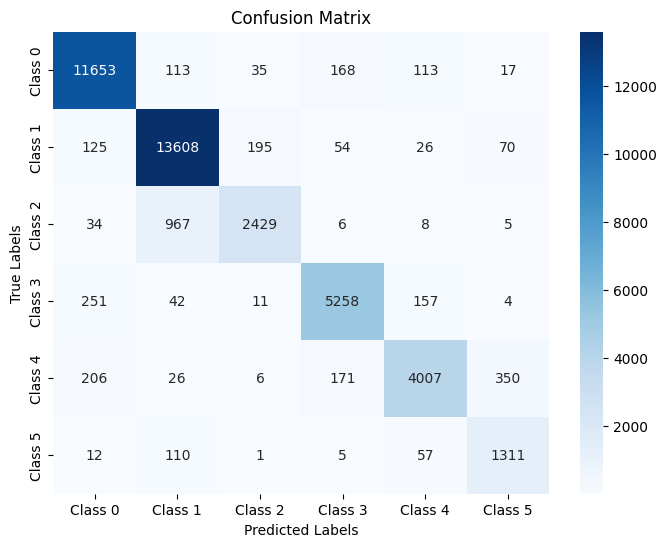


Model saved as 'word2vec_bilstm_model_6.h5'



In [ ]:
word2vec_bilstm_model_6, word2vec_bilstm_metrics_6, word2vec_bilstm_history_6 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="bilstm"
)

word2vec_bilstm_model_6.save('word2vec_bilstm_model_6.h5')
print("\nModel saved as 'word2vec_bilstm_model_6.h5'\n")

### 7. Batch 32 & LR 0.01

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 87s 8ms/step - accuracy: 0.8625 - loss: 0.3736 - val_accuracy: 0.9096 - val_loss: 0.2182
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.9005 - loss: 0.2575 - val_accuracy: 0.9122 - val_loss: 0.2093
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.9010 - loss: 0.2534 - val_accuracy: 0.9083 - val_loss: 0.2251
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 84s 8ms/step - accuracy: 0.9022 - loss: 0.2470 - val_accuracy: 0.9123 - val_loss: 0.2166
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.9030 - loss: 0.2463 - val_accuracy: 0.9107 - val_loss: 0.2152
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.9033 - loss: 0.2410 - val_accuracy: 0.9129 - val_loss: 0.2137
Epoch 7/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.9060 - loss: 0.2361 - val_accuracy: 0.9135 - val_loss: 0.2105
Epoch 7: early stopping
Restoring model weights from the end o

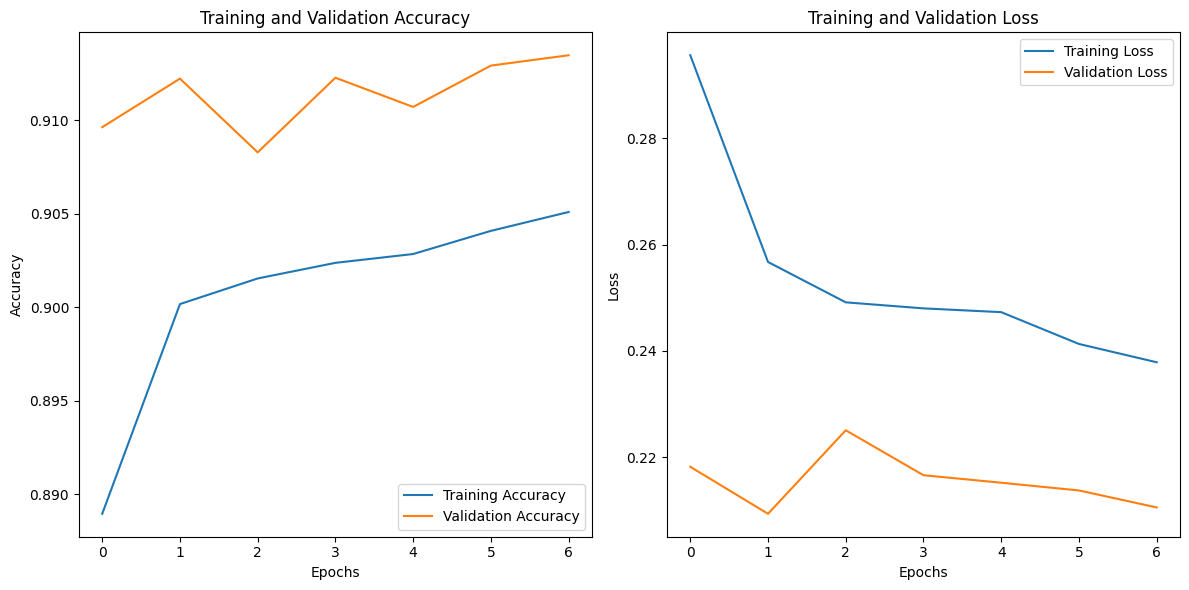

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.94      0.95     12099
           1       0.90      0.97      0.93     14078
           2       0.90      0.67      0.77      3449
           3       0.92      0.90      0.91      5723
           4       0.85      0.93      0.89      4766
           5       0.88      0.65      0.75      1496

    accuracy                           0.91     41611
   macro avg       0.90      0.84      0.87     41611
weighted avg       0.91      0.91      0.91     41611


Metrics:

Train Loss: 0.2378639429807663
Val Loss: 0.21052823960781097
Test Loss: 0.2113230675458908
AUC: 0.9936051932391686
Accuracy: 0.9109370112419128
Precision: 0.9116046981101731
Recall: 0.9109370118478287
F1-Score: 0.9085117524477033

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


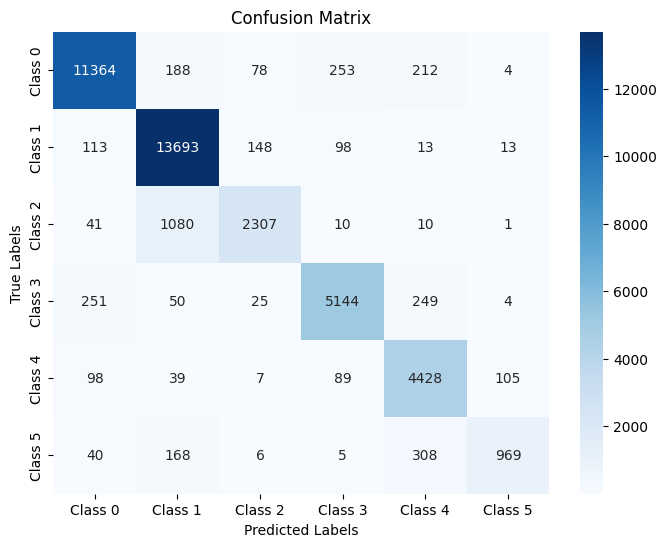


Model saved as 'word2vec_bilstm_model_7.h5'



In [ ]:
word2vec_bilstm_model_7, word2vec_bilstm_metrics_7, word2vec_bilstm_history_7 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="bilstm"
)

word2vec_bilstm_model_7.save('word2vec_bilstm_model_7.h5')
print("\nModel saved as 'word2vec_bilstm_model_7.h5'\n")

### 8. Batch 32 & LR 0.001

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 88s 8ms/step - accuracy: 0.8292 - loss: 0.4506 - val_accuracy: 0.9193 - val_loss: 0.1699
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.9179 - loss: 0.1723 - val_accuracy: 0.9208 - val_loss: 0.1605
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.9224 - loss: 0.1548 - val_accuracy: 0.9224 - val_loss: 0.1507
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 84s 8ms/step - accuracy: 0.9243 - loss: 0.1449 - val_accuracy: 0.9254 - val_loss: 0.1481
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.9263 - loss: 0.1374 - val_accuracy: 0.9255 - val_loss: 0.1459
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.9269 - loss: 0.1337 - val_accuracy: 0.9262 - val_loss: 0.1485
Epoch 7/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 84s 8ms/step - accuracy: 0.9290 - loss: 0.1309 - val_accuracy: 0.9236 - val_loss: 0.1515
Epoch 8/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - ac

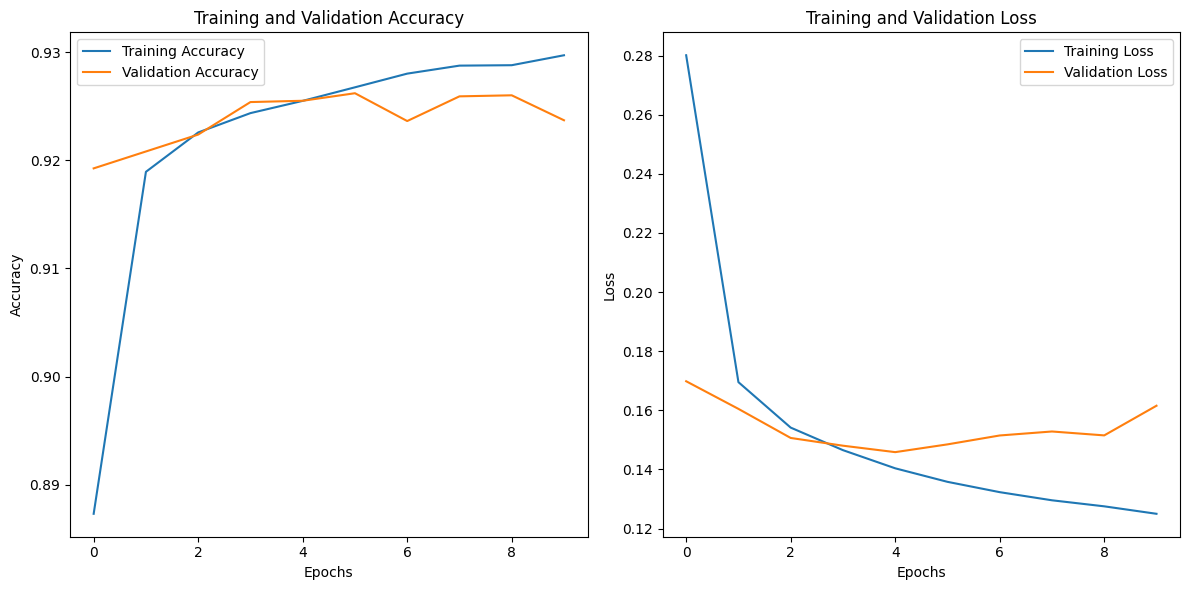

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.95      0.96     12099
           1       0.96      0.92      0.94     14078
           2       0.78      0.87      0.82      3449
           3       0.91      0.95      0.93      5723
           4       0.88      0.90      0.89      4766
           5       0.81      0.73      0.77      1496

    accuracy                           0.92     41611
   macro avg       0.88      0.89      0.88     41611
weighted avg       0.92      0.92      0.92     41611


Metrics:

Train Loss: 0.1250150352716446
Val Loss: 0.16156890988349915
Test Loss: 0.1467626541852951
AUC: 0.9962267311690772
Accuracy: 0.9199490547180176
Precision: 0.9217755989597536
Recall: 0.919949051933383
F1-Score: 0.9203636805083792

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


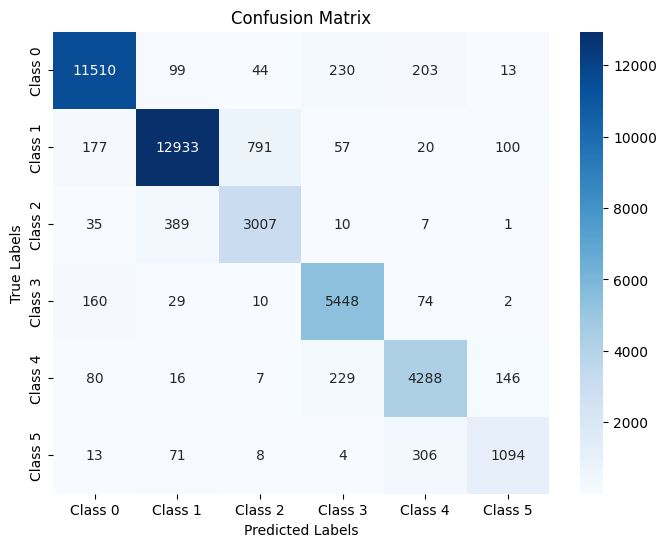


Model saved as 'word2vec_bilstm_model_8.h5'



In [ ]:
word2vec_bilstm_model_8, word2vec_bilstm_metrics_8, word2vec_bilstm_history_8 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="bilstm"
)

word2vec_bilstm_model_8.save('word2vec_bilstm_model_8.h5')
print("\nModel saved as 'word2vec_bilstm_model_8.h5'\n")

### 9. Batch 32 & LR 0.0001

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 88s 8ms/step - accuracy: 0.6553 - loss: 0.9318 - val_accuracy: 0.8588 - val_loss: 0.3691
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.8676 - loss: 0.3529 - val_accuracy: 0.8943 - val_loss: 0.2591
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.8969 - loss: 0.2643 - val_accuracy: 0.9044 - val_loss: 0.2221
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 84s 8ms/step - accuracy: 0.9075 - loss: 0.2249 - val_accuracy: 0.9098 - val_loss: 0.1995
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 85s 8ms/step - accuracy: 0.9112 - loss: 0.2046 - val_accuracy: 0.9134 - val_loss: 0.1871
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 84s 8ms/step - accuracy: 0.9155 - loss: 0.1890 - val_accuracy: 0.9137 - val_loss: 0.1808
Epoch 7/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.9187 - loss: 0.1785 - val_accuracy: 0.9163 - val_loss: 0.1729
Epoch 8/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 85s 8ms/step - ac

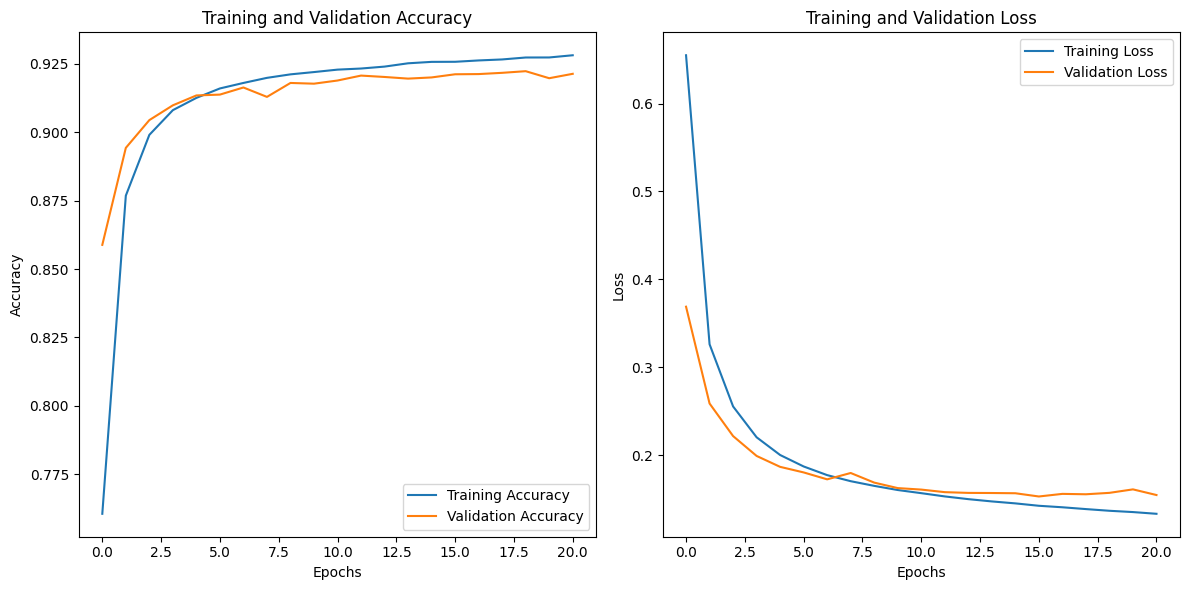

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.95      0.96     12099
           1       0.95      0.93      0.94     14078
           2       0.80      0.84      0.82      3449
           3       0.93      0.92      0.92      5723
           4       0.84      0.95      0.89      4766
           5       0.83      0.68      0.75      1496

    accuracy                           0.92     41611
   macro avg       0.89      0.88      0.88     41611
weighted avg       0.92      0.92      0.92     41611


Metrics:

Train Loss: 0.1337415874004364
Val Loss: 0.15506643056869507
Test Loss: 0.15689623355865479
AUC: 0.9958096371505029
Accuracy: 0.9190598726272583
Precision: 0.9204427579334458
Recall: 0.919059863978275
F1-Score: 0.9190200623329742

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


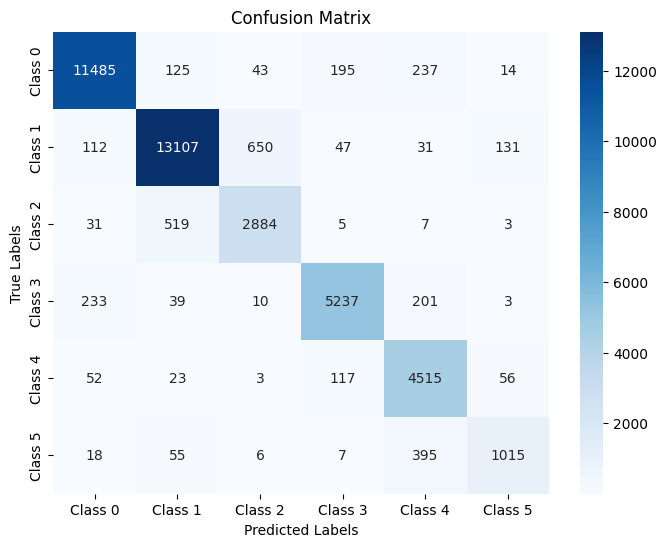


Model saved as 'word2vec_bilstm_model_9.h5'



In [ ]:
word2vec_bilstm_model_9, word2vec_bilstm_metrics_9, word2vec_bilstm_history_9 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_word2vec, y_train=train_data['label'],
    X_val=X_val_word2vec, y_val=val_data['label'],
    X_test=X_test_word2vec, y_test=test_data['label'],
    model_type="bilstm"
)

word2vec_bilstm_model_9.save('word2vec_bilstm_model_9.h5')
print("\nModel saved as 'word2vec_bilstm_model_9.h5'\n")